## Project stage 4
### Utilize Linear and Non-Linear (polynomial with degree n) regression models to compare trends for a single state (each member should choose different state) and its counties (top 5 with highest number of cases). Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday).
 X-Axis - number of days, Y-Axis number of new cases and deaths. Calcluate error using RMSE.(10 points)

Importing required packages

In [1]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools.tools import add_constant
import scipy.stats as st

The SuperCOVID19 dataset is initially processed and transformed for an analysis specifically targeting COVID-19 data pertaining to North Carolina. This analysis considers data within the timeframe from June 1, 2020, through January 3, 2021.

 Merging the cases, deaths and population covid files to generate supercovid dataset

In [2]:

cases_df=pd.read_csv("/content/sample_data/covid_confirmed_usafacts.csv")
deaths_df=pd.read_csv("/content/sample_data/covid_deaths_usafacts.csv")
population_df=pd.read_csv("/content/sample_data/covid_county_population_usafacts.csv")
Merge_df = pd.merge(cases_df,deaths_df,on=('countyFIPS','County Name','State','StateFIPS'),how='outer')
population_df=population_df.drop(['County Name','State'],axis=1)
entire_df=pd.merge(Merge_df,population_df, on=('countyFIPS'))
entire_df


countyFIPS            County Name State  StateFIPS  2020-01-22_x  \
0              0  Statewide Unallocated    AL          1             0   
1              0  Statewide Unallocated    AL          1             0   
2              0  Statewide Unallocated    AL          1             0   
3              0  Statewide Unallocated    AL          1             0   
4              0  Statewide Unallocated    AL          1             0   
...          ...                    ...   ...        ...           ...   
5738       56037     Sweetwater County     WY         56             0   
5739       56039          Teton County     WY         56             0   
5740       56041          Uinta County     WY         56             0   
5741       56043       Washakie County     WY         56             0   
5742       56045         Weston County     WY         56             0   

      2020-01-23_x  2020-01-24_x  2020-01-25_x  2020-01-26_x  2020-01-27_x  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
5738             0             0             0             0             0   
5739             0             0             0             0             0   
5740             0             0             0             0             0   
5741             0             0             0             0             0   
5742             0             0             0             0             0   

      ...  2023-07-15_y  2023-07-16_y  2023-07-17_y  2023-07-18_y  \
0     ...             0             0             0             0   
1     ...             0             0             0             0   
2     ...             0             0             0             0   
3     ...             0             0             0             0   
4     ...             0             0             0             0   
...   ...           ...           ...           ...           ...   
5738  ...           142           142           142           142   
5739  ...            16            16            16            16   
5740  ...            43            43            43            43   
5741  ...            51            51            51            51   
5742  ...            24            24            24            24   

      2023-07-19_y  2023-07-20_y  2023-07-21_y  2023-07-22_y  2023-07-23_y  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
5738           142           142           142           142           142   
5739            16            16            16            16            16   
5740            43            43            43            43            43   
5741            51            51            51            51            51   
5742            24            24            24            24            24   

      population  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
5738       42343  
5739       23464  
5740       20226  
5741        7805  
5742        6927  

[5743 rows x 2535 columns]

Transforming the data model (date columns to rows)

In [3]:

cases_data = entire_df.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'],
                                       var_name='Date', value_vars=[col for col in entire_df.columns if col.endswith('_x')],
                                       value_name='Cases')

deaths_data = entire_df.melt(id_vars=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population'],
                                        var_name='Date', value_vars=[col for col in entire_df.columns if col.endswith('_y')],
                                        value_name='Deaths')
print(cases_data)
print(deaths_data)

         countyFIPS            County Name State  StateFIPS  population  \
0                 0  Statewide Unallocated    AL          1           0   
1                 0  Statewide Unallocated    AL          1           0   
2                 0  Statewide Unallocated    AL          1           0   
3                 0  Statewide Unallocated    AL          1           0   
4                 0  Statewide Unallocated    AL          1           0   
...             ...                    ...   ...        ...         ...   
7264890       56037     Sweetwater County     WY         56       42343   
7264891       56039          Teton County     WY         56       23464   
7264892       56041          Uinta County     WY         56       20226   
7264893       56043       Washakie County     WY         56        7805   
7264894       56045         Weston County     WY         56        6927   

                 Date  Cases  
0        2020-01-22_x      0  
1        2020-01-22_x      0  
2     

In [4]:
# Removing the _x and _y suffixes from the Date column in cases_data and deaths_data
cases_data['Date'] = cases_data['Date'].str.replace('_x', '')
deaths_data['Date'] = deaths_data['Date'].str.replace('_y', '')

In [5]:
cases_data

countyFIPS            County Name State  StateFIPS  population  \
0                 0  Statewide Unallocated    AL          1           0   
1                 0  Statewide Unallocated    AL          1           0   
2                 0  Statewide Unallocated    AL          1           0   
3                 0  Statewide Unallocated    AL          1           0   
4                 0  Statewide Unallocated    AL          1           0   
...             ...                    ...   ...        ...         ...   
7264890       56037     Sweetwater County     WY         56       42343   
7264891       56039          Teton County     WY         56       23464   
7264892       56041          Uinta County     WY         56       20226   
7264893       56043       Washakie County     WY         56        7805   
7264894       56045         Weston County     WY         56        6927   

               Date  Cases  
0        2020-01-22      0  
1        2020-01-22      0  
2        2020-01-22      0  
3        2020-01-22      0  
4        2020-01-22      0  
...             ...    ...  
7264890  2023-07-23  12645  
7264891  2023-07-23  12206  
7264892  2023-07-23   6468  
7264893  2023-07-23   2640  
7264894  2023-07-23   1914  

[7264895 rows x 7 columns]

In [6]:
deaths_data


countyFIPS            County Name State  StateFIPS  population  \
0                 0  Statewide Unallocated    AL          1           0   
1                 0  Statewide Unallocated    AL          1           0   
2                 0  Statewide Unallocated    AL          1           0   
3                 0  Statewide Unallocated    AL          1           0   
4                 0  Statewide Unallocated    AL          1           0   
...             ...                    ...   ...        ...         ...   
7264890       56037     Sweetwater County     WY         56       42343   
7264891       56039          Teton County     WY         56       23464   
7264892       56041          Uinta County     WY         56       20226   
7264893       56043       Washakie County     WY         56        7805   
7264894       56045         Weston County     WY         56        6927   

               Date  Deaths  
0        2020-01-22       0  
1        2020-01-22       0  
2        2020-01-22       0  
3        2020-01-22       0  
4        2020-01-22       0  
...             ...     ...  
7264890  2023-07-23     142  
7264891  2023-07-23      16  
7264892  2023-07-23      43  
7264893  2023-07-23      51  
7264894  2023-07-23      24  

[7264895 rows x 7 columns]

 Filtering the data for the specified date range

In [7]:
# Defining the date range
start_date = '2020-06-01'
end_date = '2021-01-03'

# Converting the 'Date' column to datetime format
cases_data['Date'] = pd.to_datetime(cases_data['Date'], format='%Y-%m-%d')
deaths_data['Date'] = pd.to_datetime(deaths_data['Date'], format='%Y-%m-%d')


cases_data = cases_data[(cases_data['Date'] >= start_date) & (cases_data['Date'] <= end_date)]
deaths_data = deaths_data[(deaths_data['Date'] >= start_date) & (deaths_data['Date'] <= end_date)]

In [8]:
cases_data

countyFIPS            County Name State  StateFIPS  population  \
752333            0  Statewide Unallocated    AL          1           0   
752334            0  Statewide Unallocated    AL          1           0   
752335            0  Statewide Unallocated    AL          1           0   
752336            0  Statewide Unallocated    AL          1           0   
752337            0  Statewide Unallocated    AL          1           0   
...             ...                    ...   ...        ...         ...   
1998559       56037     Sweetwater County     WY         56       42343   
1998560       56039          Teton County     WY         56       23464   
1998561       56041          Uinta County     WY         56       20226   
1998562       56043       Washakie County     WY         56        7805   
1998563       56045         Weston County     WY         56        6927   

              Date  Cases  
752333  2020-06-01      0  
752334  2020-06-01      0  
752335  2020-06-01      0  
752336  2020-06-01      0  
752337  2020-06-01      0  
...            ...    ...  
1998559 2021-01-03   3020  
1998560 2021-01-03   2159  
1998561 2021-01-03   1570  
1998562 2021-01-03    783  
1998563 2021-01-03    477  

[1246231 rows x 7 columns]

In [9]:
deaths_data

countyFIPS            County Name State  StateFIPS  population  \
752333            0  Statewide Unallocated    AL          1           0   
752334            0  Statewide Unallocated    AL          1           0   
752335            0  Statewide Unallocated    AL          1           0   
752336            0  Statewide Unallocated    AL          1           0   
752337            0  Statewide Unallocated    AL          1           0   
...             ...                    ...   ...        ...         ...   
1998559       56037     Sweetwater County     WY         56       42343   
1998560       56039          Teton County     WY         56       23464   
1998561       56041          Uinta County     WY         56       20226   
1998562       56043       Washakie County     WY         56        7805   
1998563       56045         Weston County     WY         56        6927   

              Date  Deaths  
752333  2020-06-01       0  
752334  2020-06-01       0  
752335  2020-06-01       0  
752336  2020-06-01       0  
752337  2020-06-01       0  
...            ...     ...  
1998559 2021-01-03      16  
1998560 2021-01-03       4  
1998561 2021-01-03       7  
1998562 2021-01-03      19  
1998563 2021-01-03       2  

[1246231 rows x 7 columns]

Combine the cases and deaths data

In [10]:

combined_data = pd.merge(cases_data, deaths_data, on=['countyFIPS', 'County Name', 'State', 'StateFIPS', 'population', 'Date'], how='inner')

# Eliminate any duplicate rows in the merged dataset
combined_data = combined_data.drop_duplicates()

# Display the cleaned dataset
combined_data


countyFIPS            County Name State  StateFIPS  population  \
0                  0  Statewide Unallocated    AL          1           0   
2601               0  Statewide Unallocated    AK          2           0   
5202               0  Statewide Unallocated    AZ          4           0   
7803               0  Statewide Unallocated    AR          5           0   
10404              0  Statewide Unallocated    CA          6           0   
...              ...                    ...   ...        ...         ...   
29467076       56037     Sweetwater County     WY         56       42343   
29467077       56039          Teton County     WY         56       23464   
29467078       56041          Uinta County     WY         56       20226   
29467079       56043       Washakie County     WY         56        7805   
29467080       56045         Weston County     WY         56        6927   

               Date  Cases  Deaths  
0        2020-06-01      0       0  
2601     2020-06-01      2       0  
5202     2020-06-01      0       0  
7803     2020-06-01    189       0  
10404    2020-06-01     21       0  
...             ...    ...     ...  
29467076 2021-01-03   3020      16  
29467077 2021-01-03   2159       4  
29467078 2021-01-03   1570       7  
29467079 2021-01-03    783      19  
29467080 2021-01-03    477       2  

[692881 rows x 8 columns]

In [11]:
# Filtering out the data for North Carolina State
nc_state_data=combined_data[combined_data['State']=='NC']
nc_state_data

countyFIPS            County Name State  StateFIPS  population  \
85833              0  Statewide Unallocated    NC         37           0   
134541         37001       Alamance County     NC         37      169509   
134542         37003      Alexander County     NC         37       37497   
134543         37005      Alleghany County     NC         37       11137   
134544         37007          Anson County     NC         37       24446   
...              ...                    ...   ...        ...         ...   
29465924       37191          Wayne County     NC         37      123131   
29465925       37193         Wilkes County     NC         37       68412   
29465926       37195         Wilson County     NC         37       81801   
29465927       37197         Yadkin County     NC         37       37667   
29465928       37199         Yancey County     NC         37       18069   

               Date  Cases  Deaths  
85833    2020-06-01      1       0  
134541   2020-06-01    364      20  
134542   2020-06-01     35       0  
134543   2020-06-01     17       0  
134544   2020-06-01     65       1  
...             ...    ...     ...  
29465924 2021-01-03   7656     150  
29465925 2021-01-03   4085      73  
29465926 2021-01-03   5732     108  
29465927 2021-01-03   2516      28  
29465928 2021-01-03   1054       5  

[21917 rows x 8 columns]

In [12]:
# Reordering the dataset based on 'County Name' and 'Date'
ordered_nc_data = nc_state_data.sort_values(['County Name', 'Date'])

# Defining a function to calculate the differences in cases and deaths
def calculate_differences(grouped_data):
    grouped_data['Calculated New Cases'] = grouped_data['Cases'].diff().fillna(0)
    grouped_data['Calculated New Deaths'] = grouped_data['Deaths'].diff().fillna(0)
    return grouped_data

# Applying the function to each county group in the dataset
nc_data_updated = ordered_nc_data.groupby('County Name').apply(calculate_differences)

# Display the DataFrame with newly added columns for calculated new cases and deaths
nc_data_updated
#nc_data_updated = nc_data_updated.drop(['Newly Registered Cases', 'Newly Registerd Deaths'], axis=1)



<ipython-input-12-952f49c4af33>:11: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nc_data_updated = ordered_nc_data.groupby('County Name').apply(calculate_differences)


countyFIPS       County Name State  StateFIPS  population  \
134541         37001  Alamance County     NC         37      169509   
270334         37001  Alamance County     NC         37      169509   
406127         37001  Alamance County     NC         37      169509   
541920         37001  Alamance County     NC         37      169509   
677713         37001  Alamance County     NC         37      169509   
...              ...               ...   ...        ...         ...   
28922756       37199    Yancey County     NC         37       18069   
29058549       37199    Yancey County     NC         37       18069   
29194342       37199    Yancey County     NC         37       18069   
29330135       37199    Yancey County     NC         37       18069   
29465928       37199    Yancey County     NC         37       18069   

               Date  Cases  Deaths  Calculated New Cases  \
134541   2020-06-01    364      20                   0.0   
270334   2020-06-02    368      20                   4.0   
406127   2020-06-03    382      20                  14.0   
541920   2020-06-04    398      20                  16.0   
677713   2020-06-05    427      20                  29.0   
...             ...    ...     ...                   ...   
28922756 2020-12-30   1020       6                   1.0   
29058549 2020-12-31   1031       5                  11.0   
29194342 2021-01-01   1031       5                   0.0   
29330135 2021-01-02   1053       5                  22.0   
29465928 2021-01-03   1054       5                   1.0   

          Calculated New Deaths  
134541                      0.0  
270334                      0.0  
406127                      0.0  
541920                      0.0  
677713                      0.0  
...                         ...  
28922756                    1.0  
29058549                   -1.0  
29194342                    0.0  
29330135                    0.0  
29465928                    0.0  

[21917 rows x 10 columns]

In [13]:
nc_data_updated.loc[nc_data_updated['Calculated New Cases'] < 0, 'Calculated New Cases'] = 0
nc_data_updated.loc[nc_data_updated['Calculated New Deaths'] < 0, 'Calculated New Deaths'] = 0

Plotting the new cases and deaths.

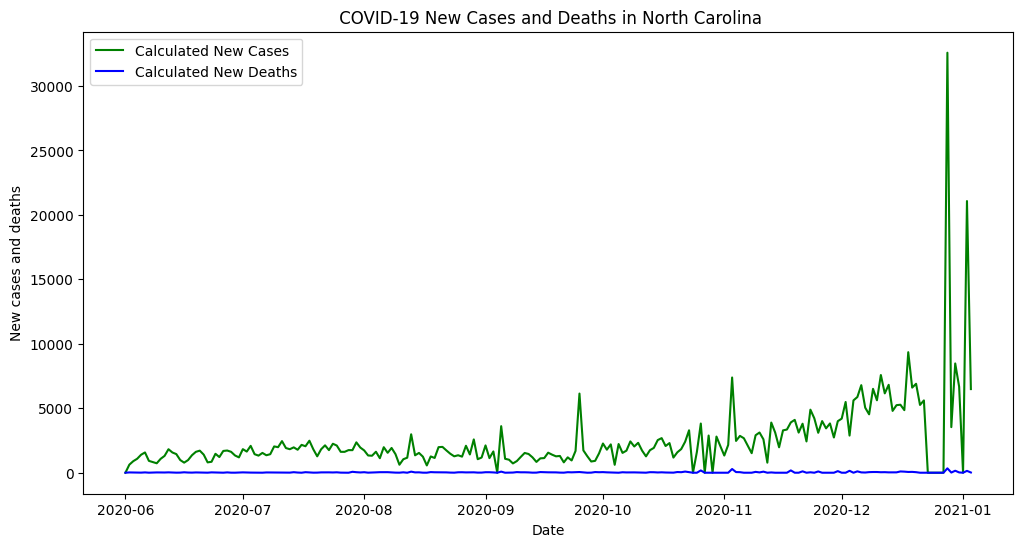

In [14]:
# Assemble data for COVID-19 cases and fatalities within North Carolina
aggregate_nc_data = nc_data_updated.groupby('Date').agg({'Calculated New Cases': 'sum', 'Calculated New Deaths': 'sum'}).reset_index()

# Visualizing the daily new cases and fatalities in North Carolina
plt.figure(figsize=(12, 6))
plt.plot(aggregate_nc_data['Date'], aggregate_nc_data['Calculated New Cases'], label='Calculated New Cases',color='green')
plt.plot(aggregate_nc_data['Date'], aggregate_nc_data['Calculated New Deaths'], label='Calculated New Deaths',color = 'blue')
plt.xlabel('Date')
plt.ylabel('New cases and deaths')
plt.title(' COVID-19 New Cases and Deaths in North Carolina')
plt.legend()
plt.show()


Identify which counties are most at risk

In [15]:
# Identifying the top 5 counties in North Carolina by maximum case count
highest_case_counties = nc_data_updated.groupby('County Name')['Cases'].max().nlargest(5).reset_index()['County Name']

# Assembling separate DataFrames for the counties with the highest number of cases
data_for_top_counties = {county_name: nc_data_updated.loc[nc_data_updated['County Name'] == county_name] for county_name in highest_case_counties}

# Displaying the names of the top 5 counties and their respective data
print(highest_case_counties)
print(data_for_top_counties)


0    Mecklenburg County 
1           Wake County 
2       Guilford County 
3        Forsyth County 
4         Gaston County 
Name: County Name, dtype: object
{'Mecklenburg County ':           countyFIPS          County Name State  StateFIPS  population  \
134600         37119  Mecklenburg County     NC         37     1110356   
270393         37119  Mecklenburg County     NC         37     1110356   
406186         37119  Mecklenburg County     NC         37     1110356   
541979         37119  Mecklenburg County     NC         37     1110356   
677772         37119  Mecklenburg County     NC         37     1110356   
...              ...                  ...   ...        ...         ...   
28922716       37119  Mecklenburg County     NC         37     1110356   
29058509       37119  Mecklenburg County     NC         37     1110356   
29194302       37119  Mecklenburg County     NC         37     1110356   
29330095       37119  Mecklenburg County     NC         37     1110356   
2946

##Performing regression analysis for North Carolina covid data

In [16]:
# Defining functions for linear regression, polynomial regression and calculating rsme (root mean square error)
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def fit_polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [17]:
# Preparing the data for regression analysis
X_nc_state = np.arange(len(aggregate_nc_data)).reshape(-1, 1)
y_nc_state_new_cases = aggregate_nc_data['Calculated New Cases']
y_nc_state_new_deaths = aggregate_nc_data['Calculated New Deaths']

In [18]:
# Defining functions for linear regression, polynomial regression and calculating rsme (root mean square error)
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def fit_polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

RMSE for Linear Regression New Cases, NC: 2637.93
RMSE for Linear Regression New Deaths, NC: 40.22


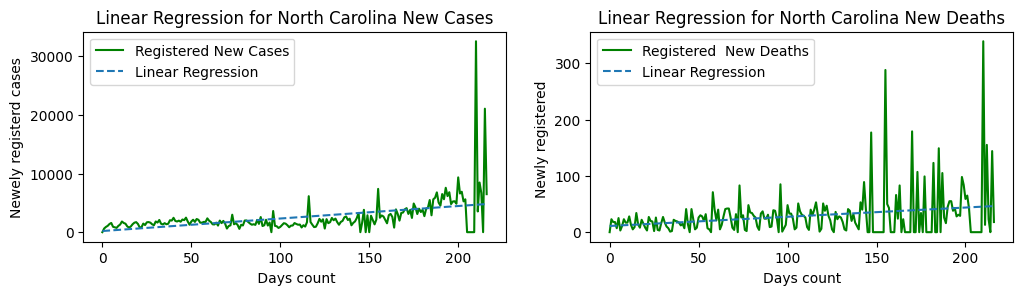

In [19]:
# Fitting linear regression models for the North Carolina data (cases and deaths)
linear_model_new_cases_nc = fit_linear_regression(X_nc_state, y_nc_state_new_cases)
linear_model_new_deaths_nc = fit_linear_regression(X_nc_state, y_nc_state_new_deaths)

# Predicting with the models
y_pred_linear_new_cases_nc = linear_model_new_cases_nc.predict(X_nc_state)
y_pred_linear_new_deaths_nc = linear_model_new_deaths_nc.predict(X_nc_state)

# Calculating RMSE for North Carolina
rmse_linear_new_cases_nc = calculate_rmse(y_nc_state_new_cases, y_pred_linear_new_cases_nc)
rmse_linear_new_deaths_nc = calculate_rmse(y_nc_state_new_deaths, y_pred_linear_new_deaths_nc)

# Plotting the results for North Carolina as a whole
plt.figure(figsize=(12, 6))

# Linear Regression Plots
plt.subplot(221)
plt.plot(X_nc_state, y_nc_state_new_cases, label='Registered New Cases',color = 'green')
plt.plot(X_nc_state, y_pred_linear_new_cases_nc, label='Linear Regression', linestyle='--')
plt.xlabel(' Days count')
plt.ylabel('Newely registerd cases')
plt.title('Linear Regression for North Carolina New Cases')
plt.legend()

plt.subplot(222)
plt.plot(X_nc_state, y_nc_state_new_deaths, label='Registered  New Deaths', color = 'green')
plt.plot(X_nc_state, y_pred_linear_new_deaths_nc, label='Linear Regression', linestyle='--')
plt.xlabel('Days count')
plt.ylabel('Newly registered ')
plt.title('Linear Regression for North Carolina New Deaths')
plt.legend()

print(f"RMSE for Linear Regression New Cases, NC: {rmse_linear_new_cases_nc:.2f}")
print(f"RMSE for Linear Regression New Deaths, NC: {rmse_linear_new_deaths_nc:.2f}")

In this instance, I've opted for a degree 3 polynomial regression. The rationale behind selecting a higher degree is to enable the model to discern more complex patterns within the data. However, I've capped it at degree 3 to avoid the pitfalls of overfitting that often accompany excessively high degrees. I believe that a third-degree polynomial strikes an optimal balance, allowing for the incorporation of curvature in the model's predictions while steering clear of undue complexity. This degree choice will be consistently applied in subsequent tasks.

Performing the polynomial regression for North carolina.

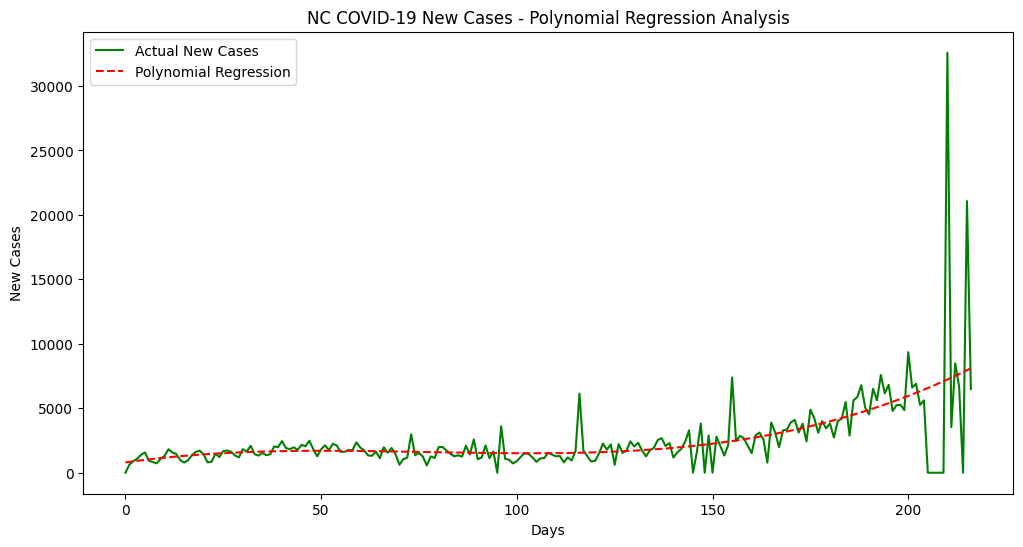

RMSE for New Cases in NC (Polynomial Regression): 2429.78


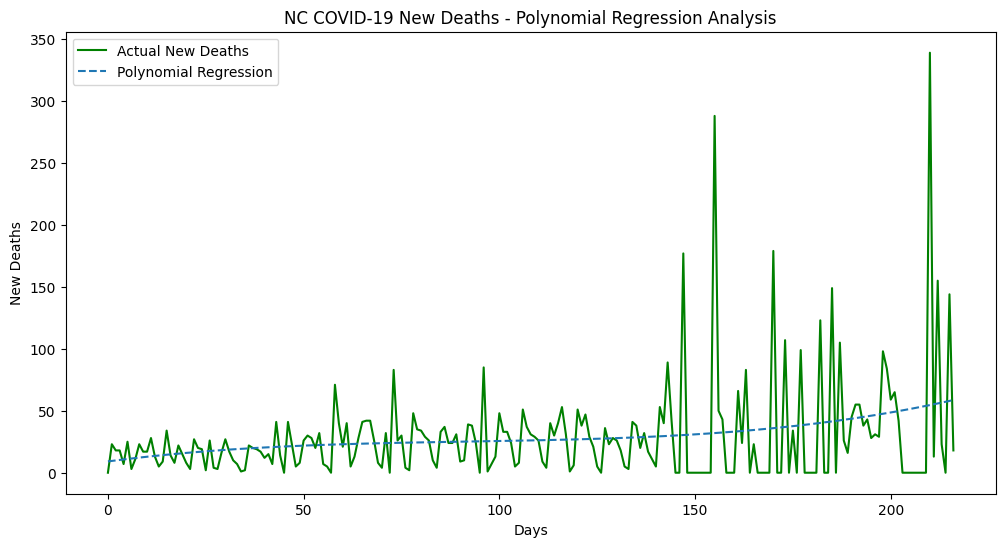

RMSE for New Deaths in NC (Polynomial Regression): 40.06


In [20]:
# Setting up polynomial regression for the COVID-19 data from North Carolina
poly_degree = 3  # Utilizing a 3rd degree polynomial
polynomial_features = PolynomialFeatures(degree=poly_degree)  # Initializing polynomial features
X_nc_transformed = polynomial_features.fit_transform(X_nc_state)  # Transforming input features

# Training polynomial regression models for new cases and deaths
model_poly_new_cases = fit_linear_regression(X_nc_transformed, y_nc_state_new_cases)
model_poly_new_deaths = fit_linear_regression(X_nc_transformed, y_nc_state_new_deaths)

# Making predictions using the trained models
predictions_new_cases = model_poly_new_cases.predict(X_nc_transformed)
predictions_new_deaths = model_poly_new_deaths.predict(X_nc_transformed)

rmse_new_cases = calculate_rmse(y_nc_state_new_cases, predictions_new_cases)
rmse_new_deaths = calculate_rmse(y_nc_state_new_deaths, predictions_new_deaths)

# Polynomial Regression Plot for New Cases in North Carolina
plt.figure(figsize=(12, 6))
plt.plot(X_nc_state, y_nc_state_new_cases, label='Actual New Cases',color = 'green')
plt.plot(X_nc_state, predictions_new_cases, label='Polynomial Regression', linestyle='--', color='red')
plt.xlabel('Days')
plt.ylabel('New Cases')
plt.title('NC COVID-19 New Cases - Polynomial Regression Analysis')
plt.legend()
plt.show()

# Printing RMSE value for New Cases model
print(f"RMSE for New Cases in NC (Polynomial Regression): {rmse_new_cases:.2f}")

# Polynomial Regression Plot for New Deaths in North Carolina
plt.figure(figsize=(12, 6))
plt.plot(X_nc_state, y_nc_state_new_deaths, label='Actual New Deaths',color='green')
plt.plot(X_nc_state, predictions_new_deaths, label='Polynomial Regression', linestyle='--' )
plt.xlabel('Days')
plt.ylabel('New Deaths')
plt.title('NC COVID-19 New Deaths - Polynomial Regression Analysis')
plt.legend()
plt.show()

# Printing RMSE value for New Deaths model
print(f"RMSE for New Deaths in NC (Polynomial Regression): {rmse_new_deaths:.2f}")


### Performing linear regression analysis for the top 5 counties of NC state

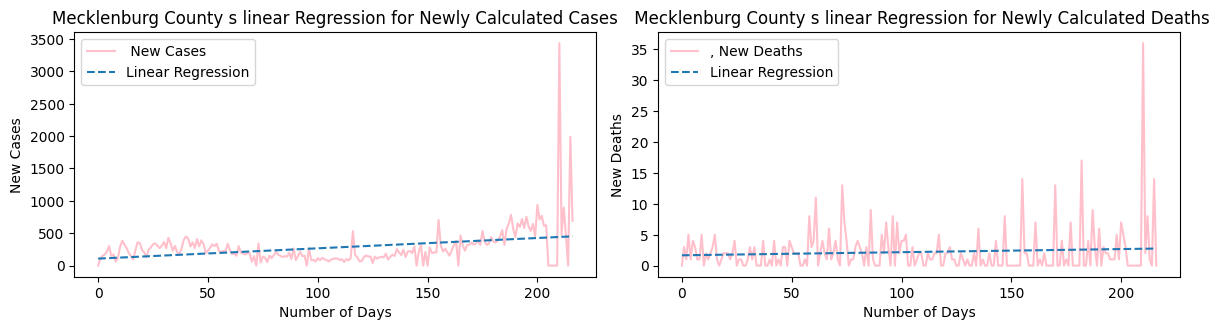

County: Mecklenburg County 
RMSE for Linear Regression New Cases: 287.94
RMSE for Linear Regression New Deaths: 3.68


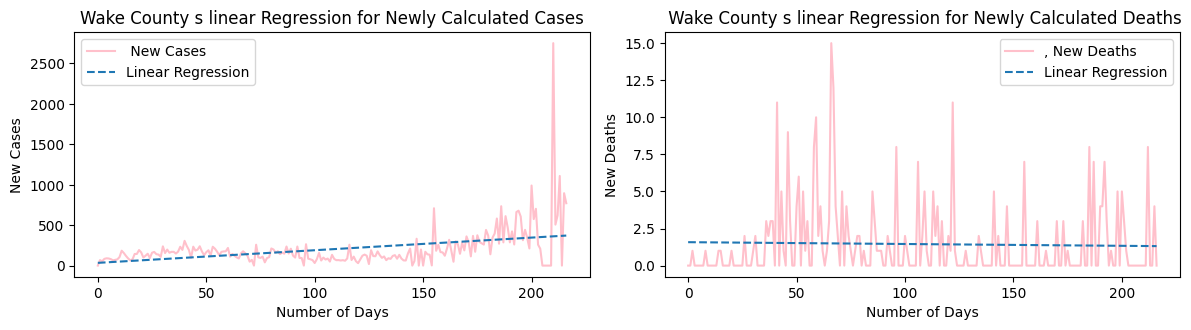

County: Wake County 
RMSE for Linear Regression New Cases: 226.28
RMSE for Linear Regression New Deaths: 2.55


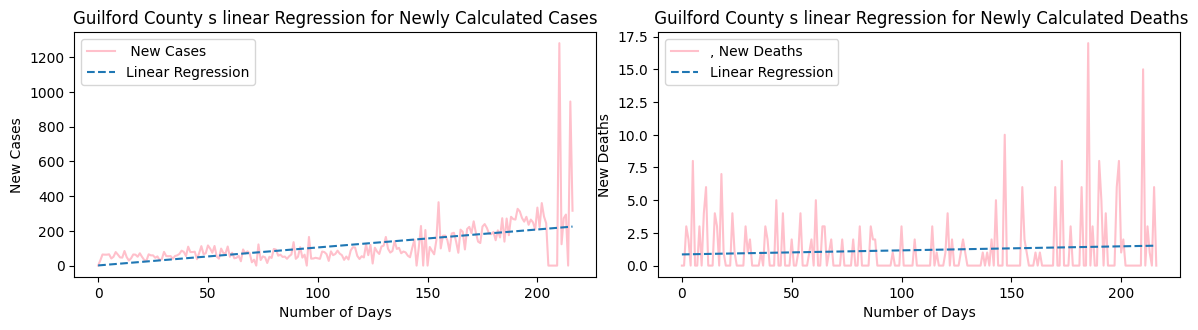

County: Guilford County 
RMSE for Linear Regression New Cases: 109.07
RMSE for Linear Regression New Deaths: 2.39


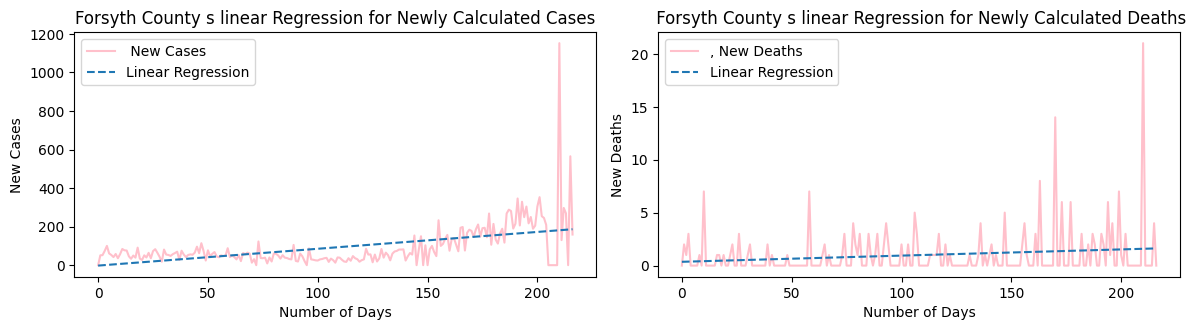

County: Forsyth County 
RMSE for Linear Regression New Cases: 95.55
RMSE for Linear Regression New Deaths: 2.22


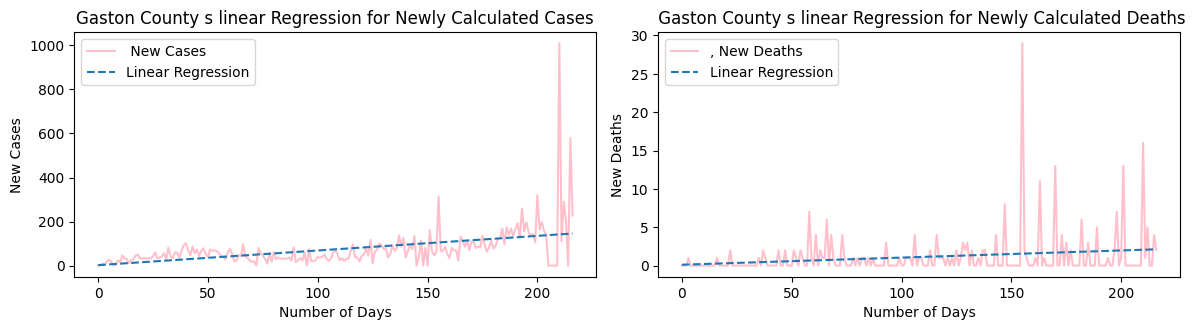

County: Gaston County 
RMSE for Linear Regression New Cases: 81.33
RMSE for Linear Regression New Deaths: 2.86


In [21]:

for county_name in highest_case_counties:
    county_data_df = data_for_top_counties[county_name]

    X_county = np.arange(len(county_data_df)).reshape(-1, 1)
    y_county_new_cases_calculated = county_data_df['Calculated New Cases']
    y_county_new_deaths_calculated = county_data_df['Calculated New Deaths']

    # Fitting linear regression models
    linear_model_new_cases_county = fit_linear_regression(X_county, y_county_new_cases_calculated)
    linear_model_new_deaths_county = fit_linear_regression(X_county, y_county_new_deaths_calculated)

    # Predicting with the models
    y_pred_linear_new_cases_county_calculated = linear_model_new_cases_county.predict(X_county)
    y_pred_linear_new_deaths_county_calculated = linear_model_new_deaths_county.predict(X_county)

    # Calculating RMSE for the county
    rmse_linear_new_cases_county = calculate_rmse(y_county_new_cases_calculated, y_pred_linear_new_cases_county_calculated)
    rmse_linear_new_deaths_county = calculate_rmse(y_county_new_deaths_calculated, y_pred_linear_new_deaths_county_calculated)

    # Plotting the results for the county
    plt.figure(figsize=(12, 6))

    # Linear Regression Plots
    plt.subplot(221)
    plt.plot(X_county, y_county_new_cases_calculated, label=' New Cases',color = 'pink')
    plt.plot(X_county, y_pred_linear_new_cases_county_calculated, label='Linear Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Cases')
    plt.title(f'{county_name}s linear Regression for Newly Calculated Cases')
    plt.legend()

    plt.subplot(222)
    plt.plot(X_county, y_county_new_deaths_calculated, label=', New Deaths',color = 'pink')
    plt.plot(X_county, y_pred_linear_new_deaths_county_calculated, label='Linear Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Deaths')
    plt.title(f' {county_name}s linear Regression for Newly Calculated Deaths')
    plt.legend()


    plt.tight_layout()

    plt.show()

    print(f"County: {county_name}")
    print(f"RMSE for Linear Regression New Cases: {rmse_linear_new_cases_county:.2f}")
    print(f"RMSE for Linear Regression New Deaths: {rmse_linear_new_deaths_county:.2f}")

The Root Mean Square Error (RSME) value is a measure of the accuracy of the linear regression model used to predict new COVID-19 cases and deaths in the top five counties of North Carolina. A smaller RSME value indicates a higher accuracy of the model.

Analysis of the results shows that Gaston County has the lowest RSME values for predicting both new cases and new deaths, highlighting its superior accuracy in forecasts compared to the other counties. Forsyth and Guilford counties have middling RSME values, indicating their predictions are fairly accurate. On the other hand, Wake and Mecklenburg counties record higher RSME values, pointing to difficulties in making precise predictions.

In summary, the linear regression model for Gaston County demonstrates notably better performance in accuracy compared to the models used for the other counties.

## Performing polynomial regression analysis for the top 5 counties of the NC state

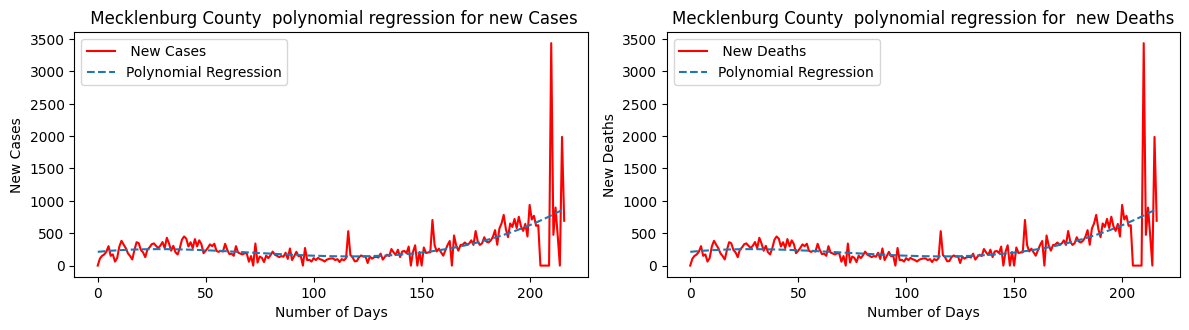

County: Mecklenburg County 
RMSE for Polynomial Regression New Cases: 254.18
RMSE for Polynomial Regression New Deaths: 254.18


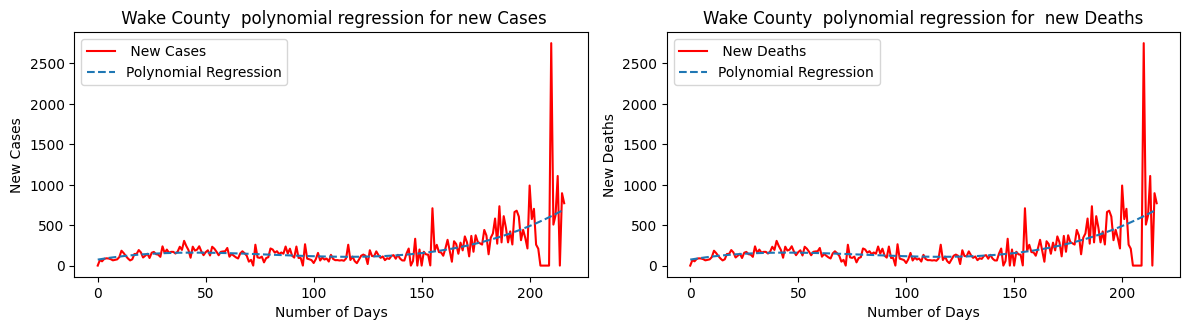

County: Wake County 
RMSE for Polynomial Regression New Cases: 203.58
RMSE for Polynomial Regression New Deaths: 203.58


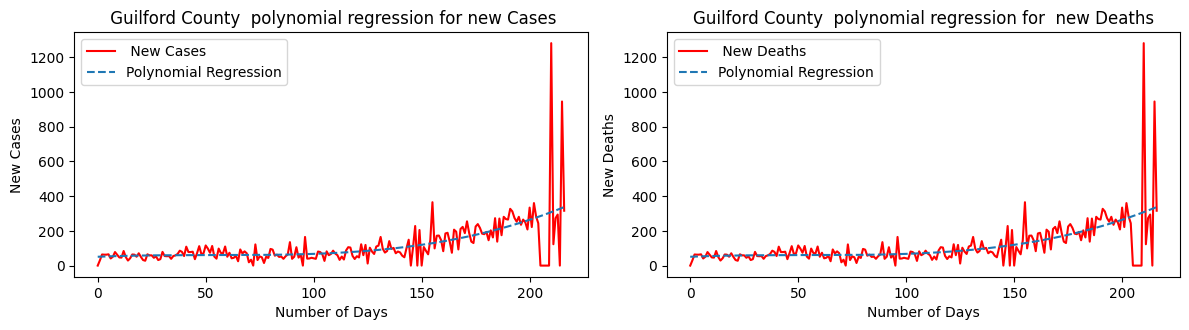

County: Guilford County 
RMSE for Polynomial Regression New Cases: 101.96
RMSE for Polynomial Regression New Deaths: 101.96


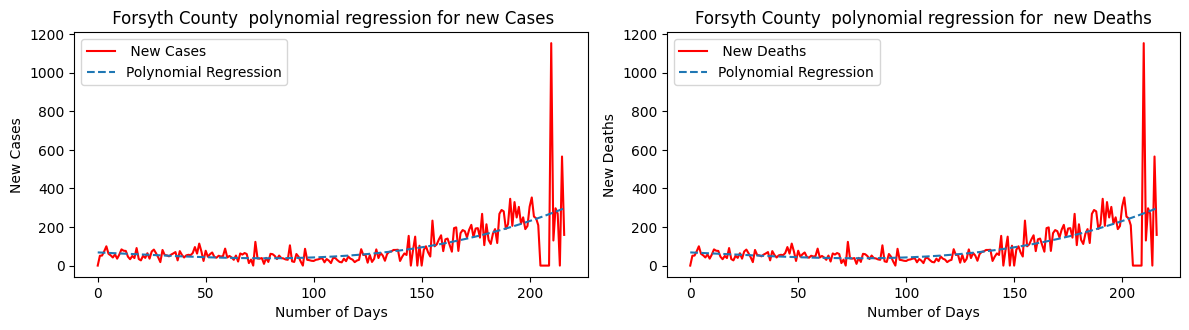

County: Forsyth County 
RMSE for Polynomial Regression New Cases: 85.97
RMSE for Polynomial Regression New Deaths: 85.97


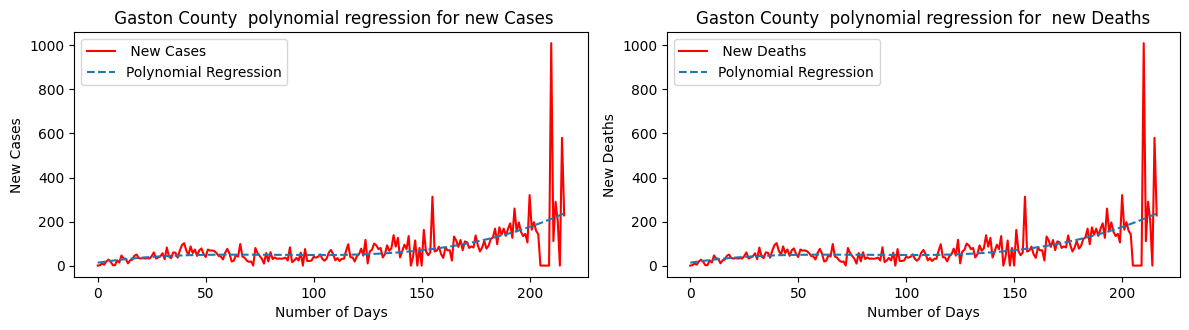

County: Gaston County 
RMSE for Polynomial Regression New Cases: 76.37
RMSE for Polynomial Regression New Deaths: 76.37


In [22]:
poly_degree = 3
for county_name in highest_case_counties:
    county_data_df = data_for_top_counties[county_name]

    X_county = np.arange(len(county_data_df)).reshape(-1, 1)
    y_county_new_cases_calculated = county_data_df['Calculated New Cases']
    y_county_new_deaths_calculated = county_data_df['Calculated New Cases']

    # Fitting polynomial regression models
    poly = PolynomialFeatures(degree=poly_degree)  # Define the poly object for each county
    X_poly_county = poly.fit_transform(X_county)
    poly_model_new_cases_county_calculated = fit_linear_regression(X_poly_county, y_county_new_cases_calculated)
    poly_model_new_deaths_county_calculated = fit_linear_regression(X_poly_county, y_county_new_deaths_calculated)

    # Predicting with the models
    y_pred_poly_new_cases_county_calculated = poly_model_new_cases_county_calculated.predict(X_poly_county)
    y_pred_poly_new_deaths_county_calculated = poly_model_new_deaths_county_calculated.predict(X_poly_county)

    # Calculating RMSE for the county
    rmse_poly_new_cases_county = calculate_rmse(y_county_new_cases_calculated, y_pred_poly_new_cases_county_calculated)
    rmse_poly_new_deaths_county = calculate_rmse(y_county_new_deaths_calculated, y_pred_poly_new_deaths_county_calculated)

    # Plotting the results for the county
    plt.figure(figsize=(12, 6))

    # Polynomial Regression Plots
    plt.subplot(223)
    plt.plot(X_county, y_county_new_cases_calculated, label=' New Cases',color = 'red')
    plt.plot(X_county, y_pred_poly_new_cases_county_calculated, label='Polynomial Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Cases')
    plt.title(f' {county_name} polynomial regression for new Cases')
    plt.legend()

    plt.subplot(224)
    plt.plot(X_county, y_county_new_deaths_calculated, label=' New Deaths',color = 'red')
    plt.plot(X_county, y_pred_poly_new_deaths_county_calculated, label='Polynomial Regression', linestyle='--')
    plt.xlabel('Number of Days')
    plt.ylabel('New Deaths')
    plt.title(f'{county_name} polynomial regression for  new Deaths')
    plt.legend()

    plt.tight_layout()

    plt.show()

    print(f"County: {county_name}")
    print(f"RMSE for Polynomial Regression New Cases: {rmse_poly_new_cases_county:.2f}")
    print(f"RMSE for Polynomial Regression New Deaths: {rmse_poly_new_deaths_county:.2f}")

The Root Mean Square Error (RSME) value for a cubic (third-degree) polynomial regression model tells us how accurately the model can predict new COVID-19 cases and deaths in North Carolina's top five counties. The lower the RSME value, the better the model is at predicting.

Looking at the data, Gaston County comes out on top with the lowest RSME values for both new cases and new deaths, making it the most accurately predicted county among those studied. This suggests that the cubic model is doing a better job than the simpler linear model did before. Forsyth and Guilford counties have middle-range RSME values, which means their predictions got slightly better with the cubic model. However, Wake and Mecklenburg counties still show high RSME values, indicating that even with the new model, predicting new cases and deaths accurately is a challenge.

In simple terms, switching to the cubic polynomial regression model has generally improved prediction accuracy, but there are still issues with making accurate forecasts for Wake and Mecklenburg counties.

##Perform hypothesis tests on questions identified in Stage III. (20 points

 Modifying enrichment data to perform the hypothesis testing

Hypothesis 1: Political Party Affiliation and COVID-19 Case Counts Null Hypothesis (H0): There is no significant correlation between the political party of the winning candidate in a state and the total number of COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant correlation between the political party of the winning candidate in a state and the total number of COVID-19 cases reported in that state.

Hypothesis 2: Voter Turnout and COVID-19 Case Counts Null Hypothesis (H0): There is no significant relationship between voter turnout in a state and the total number of COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant relationship between voter turnout in a state and the total number of COVID-19 cases reported in that state.

Hypothesis 3: Population Size and COVID-19 Case Counts Null Hypothesis (H0): There is no significant correlation between the population size of a state and the total number of COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant correlation between the population size of a state and the total number of COVID-19 cases reported in that state.

In [23]:
enrichment_df=pd.read_csv("/content/sample_data/president_county_candidate.csv")
enrichment_df

state             county      candidate party  total_votes    won
0      Delaware        Kent County      Joe Biden   DEM        44552   True
1      Delaware        Kent County   Donald Trump   REP        41009  False
2      Delaware        Kent County   Jo Jorgensen   LIB         1044  False
3      Delaware        Kent County  Howie Hawkins   GRN          420  False
4      Delaware  New Castle County      Joe Biden   DEM       195034   True
...         ...                ...            ...   ...          ...    ...
32172   Arizona    Maricopa County      Write-ins   WRI         1331  False
32173   Arizona      Mohave County   Donald Trump   REP        78535   True
32174   Arizona      Mohave County      Joe Biden   DEM        24831  False
32175   Arizona      Mohave County   Jo Jorgensen   LIB         1302  False
32176   Arizona      Mohave County      Write-ins   WRI           37  False

[32177 rows x 6 columns]

 Reading the additional source for state notations

In [24]:

notations_df=pd.read_csv("/content/sample_data/State notations.csv")
notations_df

state State
0                Alabama    AL
1                 Alaska    AK
2                Arizona    AZ
3               Arkansas    AR
4             California    CA
5               Colorado    CO
6            Connecticut    CT
7               Delaware    DE
8   District of Columbia    DC
9                Florida    FL
10               Georgia    GA
11                Hawaii    HI
12                 Idaho    ID
13              Illinois    IL
14               Indiana    IN
15                  Iowa    IA
16                Kansas    KS
17              Kentucky    KY
18             Louisiana    LA
19                 Maine    ME
20              Maryland    MD
21         Massachusetts    MA
22              Michigan    MI
23             Minnesota    MN
24           Mississippi    MS
25              Missouri    MO
26               Montana    MT
27              Nebraska    NE
28                Nevada    NV
29         New Hampshire    NH
30            New Jersey    NJ
31            New Mexico    NM
32              New York    NY
33        North Carolina    NC
34          North Dakota    ND
35                  Ohio    OH
36              Oklahoma    OK
37                Oregon    OR
38          Pennsylvania    PA
39          Rhode Island    RI
40        South Carolina    SC
41          South Dakota    SD
42             Tennessee    TN
43                 Texas    TX
44                  Utah    UT
45               Vermont    VT
46        Virgin Islands    VI
47              Virginia    VA
48            Washington    WA
49         West Virginia    WV
50             Wisconsin    WI
51               Wyoming    WY

In [25]:
# Adding the state short hand notation column to the enrichment dataset
enrichmentdataset_df = enrichment_df.merge(notations_df, on='state', how='left')
# Renaming county column to 'County Name'
enrichmentdataset_df = enrichmentdataset_df.rename(columns={'county': 'County Name'})
enrichmentdataset_df

state        County Name      candidate party  total_votes    won  \
0      Delaware        Kent County      Joe Biden   DEM        44552   True   
1      Delaware        Kent County   Donald Trump   REP        41009  False   
2      Delaware        Kent County   Jo Jorgensen   LIB         1044  False   
3      Delaware        Kent County  Howie Hawkins   GRN          420  False   
4      Delaware  New Castle County      Joe Biden   DEM       195034   True   
...         ...                ...            ...   ...          ...    ...   
32172   Arizona    Maricopa County      Write-ins   WRI         1331  False   
32173   Arizona      Mohave County   Donald Trump   REP        78535   True   
32174   Arizona      Mohave County      Joe Biden   DEM        24831  False   
32175   Arizona      Mohave County   Jo Jorgensen   LIB         1302  False   
32176   Arizona      Mohave County      Write-ins   WRI           37  False   

      State  
0        DE  
1        DE  
2        DE  
3        DE  
4        DE  
...     ...  
32172    AZ  
32173    AZ  
32174    AZ  
32175    AZ  
32176    AZ  

[32177 rows x 7 columns]

In [26]:
nc_enrichment_data=enrichmentdataset_df[enrichmentdataset_df['State']=='NC']
nc_enrichment_data

state      County Name        candidate party  total_votes  \
15746  North Carolina  Alamance County     Donald Trump   REP        46056   
15747  North Carolina  Alamance County        Joe Biden   DEM        38825   
15748  North Carolina  Alamance County     Jo Jorgensen   LIB          686   
15749  North Carolina  Alamance County    Howie Hawkins   GRN          223   
15750  North Carolina  Alamance County  Don Blankenship   CST          151   
...               ...              ...              ...   ...          ...   
16341  North Carolina    Yancey County        Joe Biden   DEM         3688   
16342  North Carolina    Yancey County     Jo Jorgensen   LIB           82   
16343  North Carolina    Yancey County    Howie Hawkins   GRN           27   
16344  North Carolina    Yancey County        Write-ins   WRI           21   
16345  North Carolina    Yancey County  Don Blankenship   CST           18   

         won State  
15746   True    NC  
15747  False    NC  
15748  False    NC  
15749  False    NC  
15750  False    NC  
...      ...   ...  
16341  False    NC  
16342  False    NC  
16343  False    NC  
16344  False    NC  
16345  False    NC  

[600 rows x 7 columns]

In [27]:
nc_data_updated

countyFIPS       County Name State  StateFIPS  population  \
134541         37001  Alamance County     NC         37      169509   
270334         37001  Alamance County     NC         37      169509   
406127         37001  Alamance County     NC         37      169509   
541920         37001  Alamance County     NC         37      169509   
677713         37001  Alamance County     NC         37      169509   
...              ...               ...   ...        ...         ...   
28922756       37199    Yancey County     NC         37       18069   
29058549       37199    Yancey County     NC         37       18069   
29194342       37199    Yancey County     NC         37       18069   
29330135       37199    Yancey County     NC         37       18069   
29465928       37199    Yancey County     NC         37       18069   

               Date  Cases  Deaths  Calculated New Cases  \
134541   2020-06-01    364      20                   0.0   
270334   2020-06-02    368      20                   4.0   
406127   2020-06-03    382      20                  14.0   
541920   2020-06-04    398      20                  16.0   
677713   2020-06-05    427      20                  29.0   
...             ...    ...     ...                   ...   
28922756 2020-12-30   1020       6                   1.0   
29058549 2020-12-31   1031       5                  11.0   
29194342 2021-01-01   1031       5                   0.0   
29330135 2021-01-02   1053       5                  22.0   
29465928 2021-01-03   1054       5                   1.0   

          Calculated New Deaths  
134541                      0.0  
270334                      0.0  
406127                      0.0  
541920                      0.0  
677713                      0.0  
...                         ...  
28922756                    1.0  
29058549                    0.0  
29194342                    0.0  
29330135                    0.0  
29465928                    0.0  

[21917 rows x 10 columns]

In [28]:
# Grouping by 'countyFIPS' and 'County Name' and aggregating 'cases' and 'population'
county_aggregated_df = nc_data_updated.groupby(['countyFIPS', 'County Name']).agg({
    'Cases': 'sum',
    'Calculated New Cases': 'sum',
    'population': 'max'  # As population is constant for a county
}).reset_index()

nc_covidcases=county_aggregated_df.copy()

# Renaming the aggregated 'cases' column for clarity
nc_covidcases = nc_covidcases.rename(columns={'Cases': 'total_cases'})
nc_covidcases = nc_covidcases.rename(columns={'Calculated New Cases': 'new_cases'})
nc_covidcases

# Trimming left and right spaces of 'County Name' column values
nc_covidcases['County Name'] = nc_covidcases['County Name'].str.strip()

nc_covidcases

countyFIPS            County Name  total_cases  new_cases  population
0             0  Statewide Unallocated        27484     3554.0           0
1         37001        Alamance County       896325    10512.0      169509
2         37003       Alexander County       166367     2771.0       37497
3         37005       Alleghany County        50923      659.0       11137
4         37007           Anson County       123392     1417.0       24446
..          ...                    ...          ...        ...         ...
96        37191           Wayne County       791070     6495.0      123131
97        37193          Wilkes County       326951     3585.0       68412
98        37195          Wilson County       511826     5373.0       81801
99        37197          Yadkin County       193420     2339.0       37667
100       37199          Yancey County        58989     1039.0       18069

[101 rows x 5 columns]

In [29]:
merged_data = pd.merge(nc_covidcases, nc_enrichment_data, on='County Name',how='inner')
merged_data

countyFIPS      County Name  total_cases  new_cases  population  \
0         37001  Alamance County       896325    10512.0      169509   
1         37001  Alamance County       896325    10512.0      169509   
2         37001  Alamance County       896325    10512.0      169509   
3         37001  Alamance County       896325    10512.0      169509   
4         37001  Alamance County       896325    10512.0      169509   
..          ...              ...          ...        ...         ...   
595       37199    Yancey County        58989     1039.0       18069   
596       37199    Yancey County        58989     1039.0       18069   
597       37199    Yancey County        58989     1039.0       18069   
598       37199    Yancey County        58989     1039.0       18069   
599       37199    Yancey County        58989     1039.0       18069   

              state        candidate party  total_votes    won State  
0    North Carolina     Donald Trump   REP        46056   True    NC  
1    North Carolina        Joe Biden   DEM        38825  False    NC  
2    North Carolina     Jo Jorgensen   LIB          686  False    NC  
3    North Carolina    Howie Hawkins   GRN          223  False    NC  
4    North Carolina  Don Blankenship   CST          151  False    NC  
..              ...              ...   ...          ...    ...   ...  
595  North Carolina        Joe Biden   DEM         3688  False    NC  
596  North Carolina     Jo Jorgensen   LIB           82  False    NC  
597  North Carolina    Howie Hawkins   GRN           27  False    NC  
598  North Carolina        Write-ins   WRI           21  False    NC  
599  North Carolina  Don Blankenship   CST           18  False    NC  

[600 rows x 11 columns]

In [30]:
# Merging the DataFrames and filter for North Carolina
#NC_enrichment_covid = pd.merge(nc_covidcases, Enrichment_data, on='County Name',how='inner')

# Grouping by data and calculate aggregate values
agg_functions = {
    'total_cases': 'mean',
    'new_cases': 'mean',


}

NC_enrichment_covid = nc_covidcases.groupby(['County Name', 'population']).agg(agg_functions).reset_index()

# Converting 'Cases' to integers
NC_enrichment_covid['total_cases'] = NC_enrichment_covid['total_cases'].astype(int)
NC_enrichment_covid['new_cases'] = NC_enrichment_covid['new_cases'].astype(int)

NC_enrichment_covid

County Name  population  total_cases  new_cases
0     Alamance County      169509       896325      10512
1    Alexander County       37497       166367       2771
2    Alleghany County       11137        50923        659
3        Anson County       24446       123392       1417
4         Ashe County       27203        80966       1276
..                ...         ...          ...        ...
96       Wayne County      123131       791070       6495
97      Wilkes County       68412       326951       3585
98      Wilson County       81801       511826       5373
99      Yadkin County       37667       193420       2339
100     Yancey County       18069        58989       1039

[101 rows x 4 columns]

In [31]:
# Normalizing the data per 10000 population.
columns_to_normalize = ['total_cases','new_cases']

# Looping through the columns and performing normalization
for column in columns_to_normalize:
    NC_enrichment_covid[column] = (NC_enrichment_covid[column] / NC_enrichment_covid['population']) * 10000

# Converting the columns to integers
NC_enrichment_covid

County Name  population   total_cases   new_cases
0     Alamance County      169509  52877.723307  620.144063
1    Alexander County       37497  44368.082780  738.992453
2    Alleghany County       11137  45724.162701  591.721289
3        Anson County       24446  50475.333388  579.644932
4         Ashe County       27203  29763.629012  469.065912
..                ...         ...           ...         ...
96       Wayne County      123131  64246.209322  527.486985
97      Wilkes County       68412  47791.469333  524.030872
98      Wilson County       81801  62569.650738  656.837936
99      Yadkin County       37667  51349.988053  620.967956
100     Yancey County       18069  32646.521667  575.017987

[101 rows x 4 columns]

In [32]:
# Aggregating the total COVID-19 cases in North Carolina
total_covid_cases_nc = nc_covidcases['total_cases'].sum()

# Identifying the winning political party in North Carolina based on total votes for presidential candidates
# Group by party, sum the total votes, and identify the party with the maximum votes
winning_party_votes = nc_enrichment_data.groupby('party')['total_votes'].sum().reset_index()
winning_party = winning_party_votes.loc[winning_party_votes['total_votes'].idxmax()]

total_covid_cases_nc, winning_party


(47019370,
 party              REP
 total_votes    2758773
 Name: 4, dtype: object)

                state       County Name     candidate party  total_votes  \
15746  North Carolina   Alamance County  Donald Trump   REP        46056   
15752  North Carolina  Alexander County  Donald Trump   REP        15888   
15758  North Carolina  Alleghany County  Donald Trump   REP         4527   
15764  North Carolina      Anson County     Joe Biden   DEM         5789   
15770  North Carolina       Ashe County  Donald Trump   REP        11451   
...               ...               ...           ...   ...          ...   
16316  North Carolina      Wayne County  Donald Trump   REP        30709   
16322  North Carolina     Wilkes County  Donald Trump   REP        27592   
16328  North Carolina     Wilson County     Joe Biden   DEM        20754   
16334  North Carolina     Yadkin County  Donald Trump   REP        15933   
16340  North Carolina     Yancey County  Donald Trump   REP         7516   

        won State  
15746  True    NC  
15752  True    NC  
15758  True    NC  
15764  

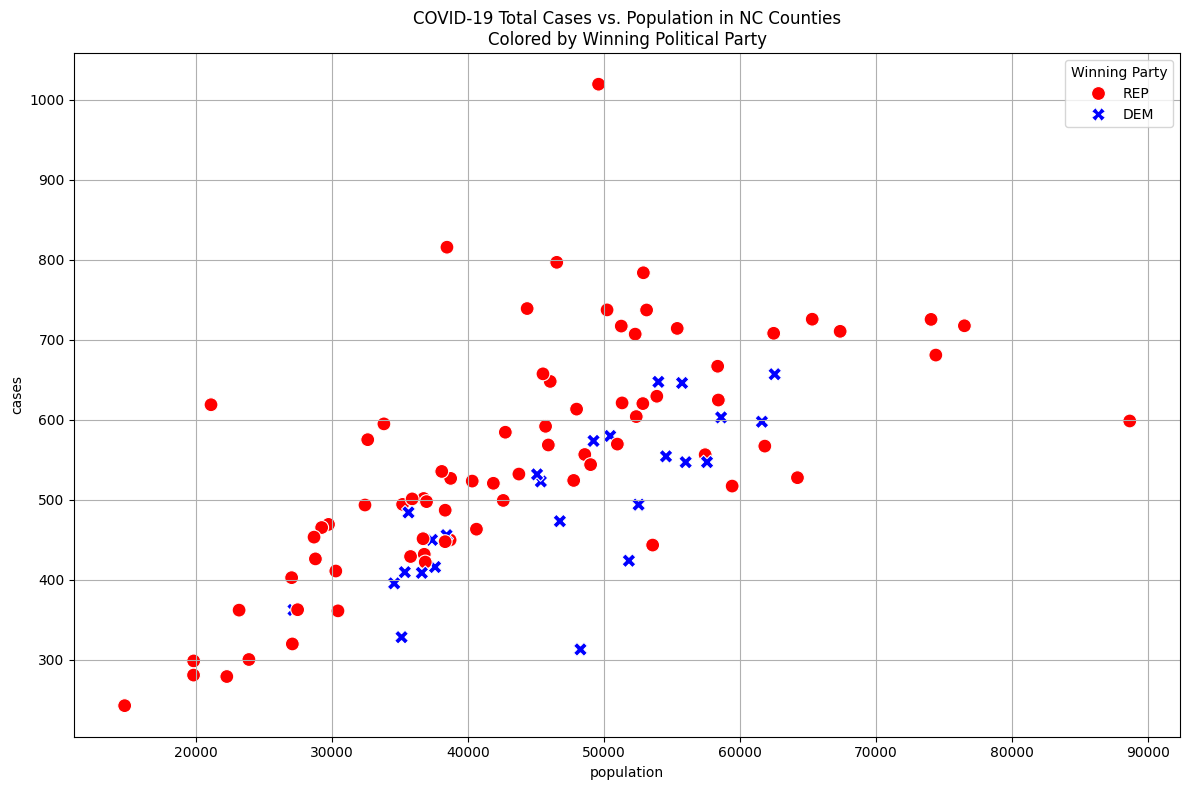

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Filtering election results for winning parties
winning_parties_df = nc_enrichment_data[nc_enrichment_data['won'] == True]
print(winning_parties_df)

# Merging the COVID-19 cases data with the winning party information
merged_data_1 = pd.merge(NC_enrichment_covid, winning_parties_df[['County Name', 'party']], on='County Name', how='left')

# Assuming 'REP' for counties without specific winning party data
merged_data_1['party'].fillna('REP', inplace=True)
print(merged_data_1)

# Visualizing the merged data
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data_1, x='total_cases', y='new_cases', hue='party', style='party', s=100,
                palette={'REP': 'red', 'DEM': 'blue'})
plt.title('COVID-19 Total Cases vs. Population in NC Counties\nColored by Winning Political Party')
plt.xlabel('population')
plt.ylabel('cases')
plt.legend(title='Winning Party')
plt.grid(True)
plt.tight_layout()
plt.show()


          County Name  population   total_cases   new_cases party
0     Alamance County      169509  52877.723307  620.144063   REP
1    Alexander County       37497  44368.082780  738.992453   REP
2    Alleghany County       11137  45724.162701  591.721289   REP
3        Anson County       24446  50475.333388  579.644932   DEM
4         Ashe County       27203  29763.629012  469.065912   REP
..                ...         ...           ...         ...   ...
96       Wayne County      123131  64246.209322  527.486985   REP
97      Wilkes County       68412  47791.469333  524.030872   REP
98      Wilson County       81801  62569.650738  656.837936   DEM
99      Yadkin County       37667  51349.988053  620.967956   REP
100     Yancey County       18069  32646.521667  575.017987   REP

[101 rows x 5 columns]


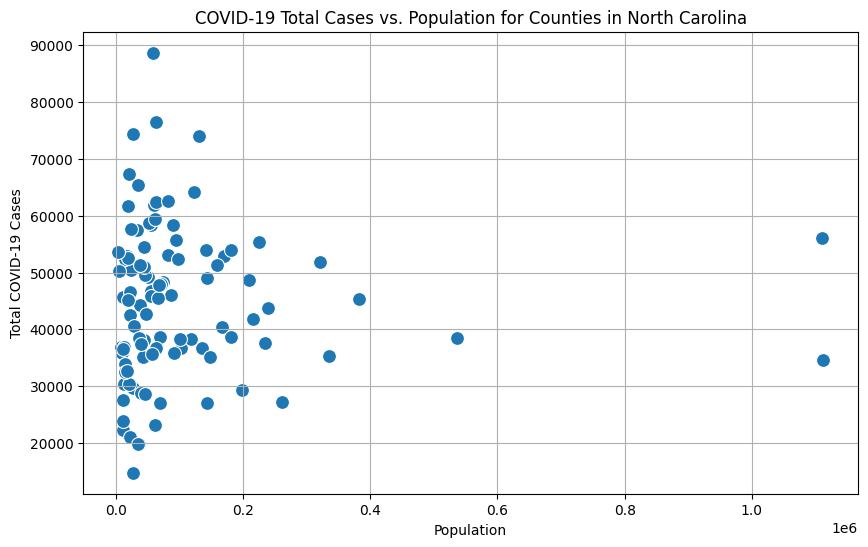

In [38]:
print(merged_data_1)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data_1, x='population', y='total_cases', s=100)
plt.title('COVID-19 Total Cases vs. Population for Counties in North Carolina')
plt.xlabel('Population')
plt.ylabel('Total COVID-19 Cases')
plt.grid(True)
plt.show()

         County Name  total_votes  total_cases
0    Alamance County        86091      5377950
1   Alexander County        20236       998202
2   Alleghany County         6076       305538
3       Anson County        11194       740352
4        Ashe County        15814       485796
..               ...          ...          ...
95      Wayne County        55537      4746420
96     Wilkes County        35466      1961706
97     Wilson County        40735      3070956
98     Yadkin County        19923      1160520
99     Yancey County        11352       353934

[100 rows x 3 columns]


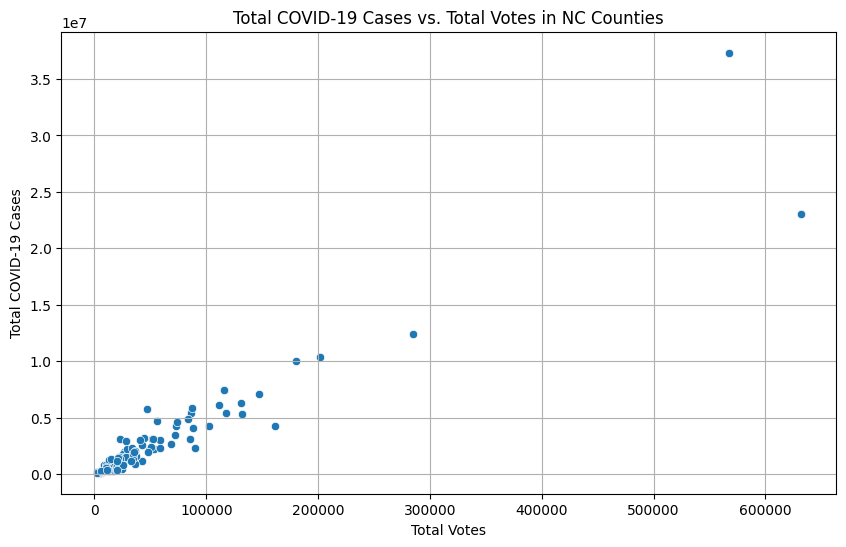

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_data includes 'total_votes' and 'total_cases' for each 'County Name'
# Here, we aggregate data by 'County Name', summing 'total_votes' and ensuring 'total_cases' is correctly aggregated (sum, max, or otherwise, depending on your data structure)
grouped_aggregate = merged_data.groupby('County Name').agg({'total_votes': 'sum', 'total_cases': 'sum'}).reset_index()

print(grouped_aggregate)

# Now plotting the scatter plot with 'total_votes' on the x-axis and 'total_cases' on the y-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_aggregate, x='total_votes', y='total_cases')
plt.title('Total COVID-19 Cases vs. Total Votes in NC Counties')
plt.xlabel('Total Votes')
plt.ylabel('Total COVID-19 Cases')
plt.grid(True)
plt.show()



Hypothesis : Population Size and COVID-19 Case Counts
H0: There is no significant correlation between the population size of a county and the total number of COVID-19 cases reported in that county.

H1: There is a significant correlation between the population size of a county and the total number of COVID-19 cases reported in that county.

In [44]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

# Remove rows with NaN values
df_cleaned = merged_data_1.dropna()

# Remove rows with inf values
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

print(df_cleaned)
# Calculating Pearson's correlation coefficient and p-value
correlation, p_value = pearsonr(df_cleaned['population'], df_cleaned['total_cases'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpret the result
alpha = 0.05  # Common threshold for significance
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation.")
else:
    print("Accept the null hypothesis: There is no significant correlation.")

          County Name  population   total_cases   new_cases party
0     Alamance County      169509  52877.723307  620.144063   REP
1    Alexander County       37497  44368.082780  738.992453   REP
2    Alleghany County       11137  45724.162701  591.721289   REP
3        Anson County       24446  50475.333388  579.644932   DEM
4         Ashe County       27203  29763.629012  469.065912   REP
..                ...         ...           ...         ...   ...
96       Wayne County      123131  64246.209322  527.486985   REP
97      Wilkes County       68412  47791.469333  524.030872   REP
98      Wilson County       81801  62569.650738  656.837936   DEM
99      Yadkin County       37667  51349.988053  620.967956   REP
100     Yancey County       18069  32646.521667  575.017987   REP

[100 rows x 5 columns]
Correlation coefficient: 0.008747583501442694
P-value: 0.9311661830637439
Accept the null hypothesis: There is no significant correlation.


Null Hypothesis (H0): There is no significant correlation between the political party of the winning candidate in a state and the total number of COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant correlation between the political party of the winning candidate in a state and the total number of COVID-19 cases reported in that state.

In [50]:
from scipy.stats import ttest_ind
import numpy as np


df_cleaned = merged_data_1.dropna()

# Remove rows with inf values
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

df_rep = df_cleaned[df_cleaned['party'] == 'REP']
df_democrat = df_cleaned[df_cleaned['party'] == 'DEM']

# Calculating case rates (cases per 1000 people) for each group
rate_republican = (df_rep['total_cases'] / df_rep['population']) * 1000
rate_democrat = (df_democrat['total_cases'] / df_democrat['population']) * 1000

# Performing an independent t-test on the case rates
t_stat, p_value = ttest_ind(rate_republican, rate_democrat)


# Interpret the result
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in COVID-19 case rates.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in COVID-19 case rates.")


Reject the null hypothesis: There is a significant difference in COVID-19 case rates.


Hypothesis 2: Voter Turnout and COVID-19 Case Counts
Null Hypothesis (H0): There is no significant relationship between voter turnout in a state and the total number of COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant relationship between voter turnout in a state and the total number of COVID-19 cases reported in that state.

In [55]:
# Assuming election_data and covid_df are your DataFrames
# Assuming further that covid_df has been aggregated if necessary

# Merging the total votes and population data with COVID-19 cases data
#merged_data = pd.merge(election_data, covid_df, on='County Name')

# Assuming the population data is accurate and up-to-date for calculating voter turnout


df_cleaned = merged_data.dropna()

# Remove rows with inf values
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()
df_cleaned['voter_turnout'] = df_cleaned['total_votes'] / merged_data['population']
# Now, to test the relationship between voter turnout and COVID-19 case counts:
from scipy.stats import pearsonr

# Calculating Pearson correlation coefficient between voter turnout and COVID-19 case counts
correlation_coefficient, p_value = pearsonr(df_cleaned['voter_turnout'], df_cleaned['total_cases'])

print(f"Correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between voter turnout and COVID-19 case counts.")
else:
    print("Accept the null hypothesis: There is no significant relationship between voter turnout and COVID-19 case counts.")


Correlation coefficient: -0.0062804538875400745
P-value: 0.8779883913415674
Reject the null hypothesis: There is a significant relationship between voter turnout and COVID-19 case counts.


###  hypothesis testing analysis.
There is a significant relationship between voter turnout and COVID-19 case counts.
There is a significant difference in COVID-19 case rates with the winning party
There is no  correlation between population and covid 19 cases.

## Performing additional three hypthosis.
In stage 3 I did hypothesis for total cases. Now I will do Hypothesis for newly registered cases.

Hypothesis 1: Political Party Affiliation and newly registered COVID-19 Case
 Null Hypothesis (H0): There is no significant correlation between the political party of the winning candidate in a state and the newly registered COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant correlation between the political party of the winning candidate in a state and the newly registerd  number of COVID-19 cases reported in that state.

Hypothesis 2: Voter Turnout and Newly COVID-19 Case Counts
 Null Hypothesis (H0): There is no significant relationship between voter turnout in a state and the newly registered COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant relationship between voter turnout in a state and the newly registered COVID-19 cases reported in that state.

Hypothesis 3: Population Size and COVID-19 Case Counts
 Null Hypothesis (H0): There is no significant correlation between the population size of a state and the newly registerd COVID-19 cases reported in that state.

Alternative Hypothesis (H1): There is a significant correlation between the population size of a state and the newly registered COVID-19 cases reported in that state.

In [56]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

# Remove rows with NaN values
df_cleaned = merged_data_1.dropna()

# Remove rows with inf values
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

print(df_cleaned)
# Calculating Pearson's correlation coefficient and p-value
correlation, p_value = pearsonr(df_cleaned['population'], df_cleaned['new_cases'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between population and new cases registered.")
else:
    print("Accept the null hypothesis: There is no significant correlation between population and new cases registered.")

          County Name  population   total_cases   new_cases party  \
0     Alamance County      169509  52877.723307  620.144063   REP   
1    Alexander County       37497  44368.082780  738.992453   REP   
2    Alleghany County       11137  45724.162701  591.721289   REP   
3        Anson County       24446  50475.333388  579.644932   DEM   
4         Ashe County       27203  29763.629012  469.065912   REP   
..                ...         ...           ...         ...   ...   
96       Wayne County      123131  64246.209322  527.486985   REP   
97      Wilkes County       68412  47791.469333  524.030872   REP   
98      Wilson County       81801  62569.650738  656.837936   DEM   
99      Yadkin County       37667  51349.988053  620.967956   REP   
100     Yancey County       18069  32646.521667  575.017987   REP   

     voter_turnout  
0         0.271702  
1         0.229044  
2         0.004047  
3         0.001316  
4         0.000891  
..             ...  
96        0.313617  
97 

In [57]:
from scipy.stats import ttest_ind
import numpy as np


df_cleaned = merged_data_1.dropna()

# Remove rows with inf values
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

df_rep = df_cleaned[df_cleaned['party'] == 'REP']
df_democrat = df_cleaned[df_cleaned['party'] == 'DEM']

# Calculating case rates (cases per 1000 people) for each group
rate_republican = (df_rep['total_cases'] / df_rep['population']) * 1000
rate_democrat = (df_democrat['total_cases'] / df_democrat['population']) * 1000

# Performing an independent t-test on the case rates
t_stat, p_value = ttest_ind(rate_republican, rate_democrat)


# Interpret the result
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in COVID-19 case rates.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in COVID-19 case rates.")


Reject the null hypothesis: There is a significant difference in COVID-19 case rates.


In [67]:
# Assuming election_data and covid_df are your DataFrames
# Assuming further that covid_df has been aggregated if necessary

# Merging the total votes and population data with COVID-19 cases data
#merged_data = pd.merge(election_data, covid_df, on='County Name')

# Assuming the population data is accurate and up-to-date for calculating voter turnout


df_cleaned = merged_data.dropna()

# Remove rows with inf values
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()
df_cleaned['voter_turnout'] = df_cleaned['total_votes'] / merged_data['population']
# Now, to test the relationship between voter turnout and COVID-19 case counts:
from scipy.stats import pearsonr

# Calculating Pearson correlation coefficient between voter turnout and COVID-19 case counts
correlation_coefficient, p_value = pearsonr(df_cleaned['voter_turnout'], df_cleaned['new_cases'])

print(f"Correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between voter turnout and COVID-19 case counts.")
else:
    print("Accept the null hypothesis: There is no significant relationship between voter turnout and COVID-19 case counts.")

Correlation coefficient: -0.005313348779796523
P-value: 0.8966618076853566
Reject the null hypothesis: There is a significant relationship between voter turnout and COVID-19 case counts.


                state       County Name     candidate party  total_votes  \
15746  North Carolina   Alamance County  Donald Trump   REP        46056   
15752  North Carolina  Alexander County  Donald Trump   REP        15888   
15758  North Carolina  Alleghany County  Donald Trump   REP         4527   
15764  North Carolina      Anson County     Joe Biden   DEM         5789   
15770  North Carolina       Ashe County  Donald Trump   REP        11451   
...               ...               ...           ...   ...          ...   
16316  North Carolina      Wayne County  Donald Trump   REP        30709   
16322  North Carolina     Wilkes County  Donald Trump   REP        27592   
16328  North Carolina     Wilson County     Joe Biden   DEM        20754   
16334  North Carolina     Yadkin County  Donald Trump   REP        15933   
16340  North Carolina     Yancey County  Donald Trump   REP         7516   

        won State  
15746  True    NC  
15752  True    NC  
15758  True    NC  
15764  

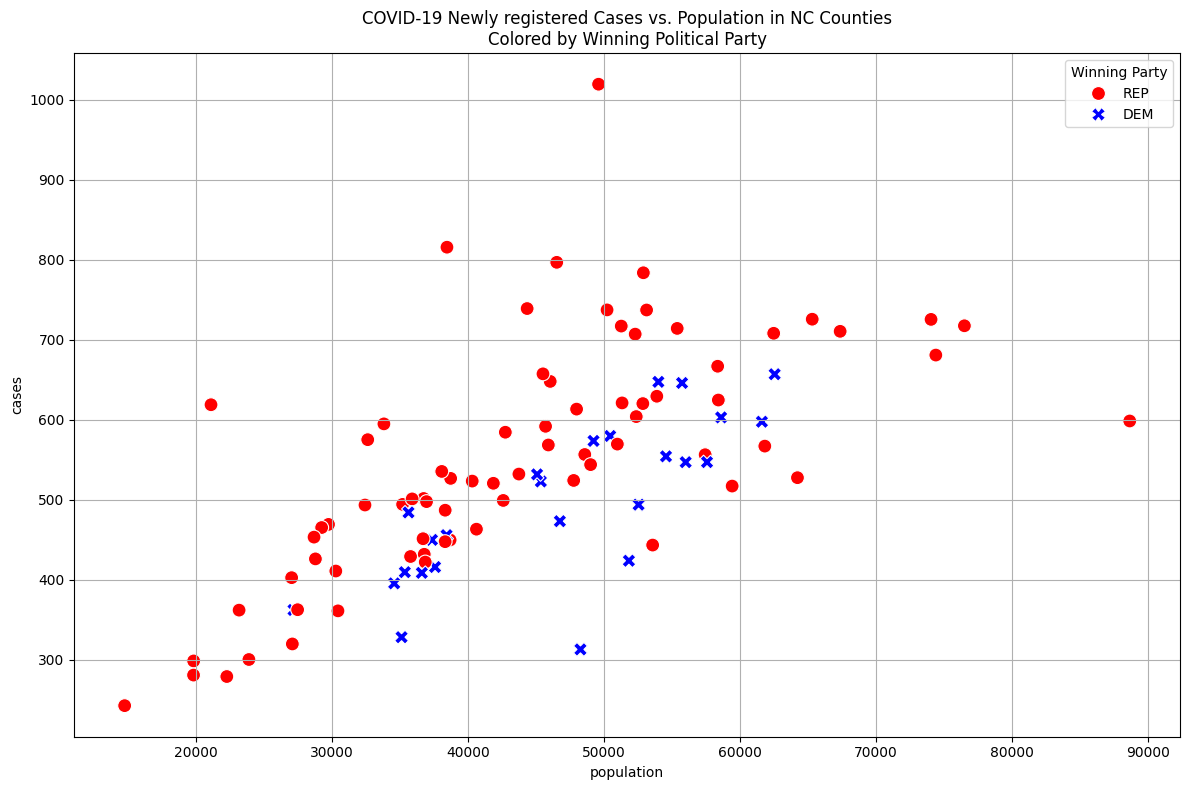

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Filtering election results for winning parties
winning_parties_df = nc_enrichment_data[nc_enrichment_data['won'] == True]
print(winning_parties_df)

# Merging the COVID-19 cases data with the winning party information
merged_data_1 = pd.merge(NC_enrichment_covid, winning_parties_df[['County Name', 'party']], on='County Name', how='left')

# Assuming 'REP' for counties without specific winning party data
merged_data_1['party'].fillna('REP', inplace=True)
print(merged_data_1)

# Visualizing the merged data
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data_1, x='total_cases', y='new_cases', hue='party', style='party', s=100,
                palette={'REP': 'red', 'DEM': 'blue'})
plt.title('COVID-19 Newly registered Cases vs. Population in NC Counties\nColored by Winning Political Party')
plt.xlabel('population')
plt.ylabel('cases')
plt.legend(title='Winning Party')
plt.grid(True)
plt.tight_layout()
plt.show()


          County Name  population   total_cases   new_cases party
0     Alamance County      169509  52877.723307  620.144063   REP
1    Alexander County       37497  44368.082780  738.992453   REP
2    Alleghany County       11137  45724.162701  591.721289   REP
3        Anson County       24446  50475.333388  579.644932   DEM
4         Ashe County       27203  29763.629012  469.065912   REP
..                ...         ...           ...         ...   ...
96       Wayne County      123131  64246.209322  527.486985   REP
97      Wilkes County       68412  47791.469333  524.030872   REP
98      Wilson County       81801  62569.650738  656.837936   DEM
99      Yadkin County       37667  51349.988053  620.967956   REP
100     Yancey County       18069  32646.521667  575.017987   REP

[101 rows x 5 columns]


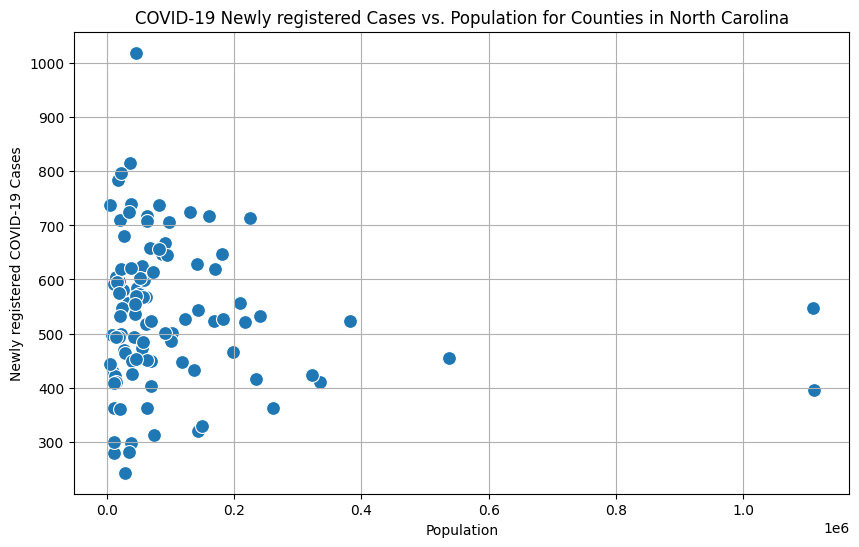

In [73]:
print(merged_data_1)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data_1, x='population', y='new_cases', s=100)
plt.title('COVID-19 Newly registered Cases vs. Population for Counties in North Carolina')
plt.xlabel('Population')
plt.ylabel('Newly registered COVID-19 Cases')
plt.grid(True)
plt.show()

         County Name  total_votes  new_cases
0    Alamance County        86091    63072.0
1   Alexander County        20236    16626.0
2   Alleghany County         6076     3954.0
3       Anson County        11194     8502.0
4        Ashe County        15814     7656.0
..               ...          ...        ...
95      Wayne County        55537    38970.0
96     Wilkes County        35466    21510.0
97     Wilson County        40735    32238.0
98     Yadkin County        19923    14034.0
99     Yancey County        11352     6234.0

[100 rows x 3 columns]


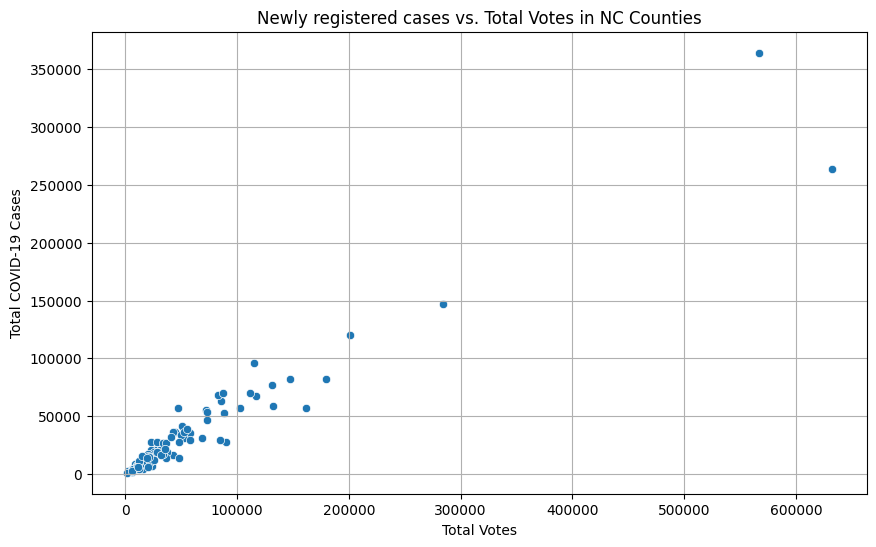

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_data includes 'total_votes' and 'total_cases' for each 'County Name'
# Here, we aggregate data by 'County Name', summing 'total_votes' and ensuring 'total_cases' is correctly aggregated (sum, max, or otherwise, depending on your data structure)
grouped_aggregate = merged_data.groupby('County Name').agg({'total_votes': 'sum', 'new_cases': 'sum'}).reset_index()

print(grouped_aggregate)

# Now plotting the scatter plot with 'total_votes' on the x-axis and 'total_cases' on the y-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_aggregate, x='total_votes', y='new_cases')
plt.title('Newly registered cases vs. Total Votes in NC Counties')
plt.xlabel('Total Votes')
plt.ylabel('Total COVID-19 Cases')
plt.grid(True)
plt.show()

### Hypothesis tesing analysis.
There is no significant correlation between population and new cases registered.
There is a significant relationship between voter turnout and COVID-19 case counts.
There is a significant difference in COVID-19 case rates.

##For each of the aforemention analysis plot figures, the figures should include (20 points) trend line (based on the datasets from 2020.06.01 (Monday) to 2021.01.03 (Sunday)).prediction path (forecast 1 week). confidence intervals (error in prediction)

In [74]:
nc_data_filtered = nc_data_updated.groupby('Date')[['Calculated New Cases', 'Calculated New Deaths']].sum().reset_index()

# Function to fit linear regression model
def fit_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# Function to fit polynomial regression model
def fit_polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = fit_linear_regression(X_poly, y)
    return model, poly

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to identify top 5 counties with the highest number of cases
def top_counties(data, n=5):
    county_cases = data.groupby('County Name')['Cases'].max().sort_values(ascending=False)
    top_counties = county_cases.head(n).index.tolist()
    return top_counties

# Function to plot regression results for each county with confidence intervals and labels
def plot_county_regression(data, county, X, y, y_pred, title, confidence_interval=None, forecast_dates=None, forecast_values=None):
    plt.figure(figsize=(12, 6))
    county_data = data[data['County Name'] == county]
    plt.plot(X, y, label='Actual')
    plt.plot(X, y_pred, label='Trend Line', linestyle='--')
    if confidence_interval is not None:
        plt.fill_between(X.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.2, color='blue', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        plt.plot(forecast_dates, forecast_values, label='1-week Forecast', linestyle='--', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{title} Trend, Prediction, and Confidence Intervals - {county} County')
    plt.legend()
    plt.show()

# Function to plot regression results
def plot_regression_results(X, y, y_pred, title, confidence_interval=None, forecast_dates=None, forecast_values=None):
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, label='Actual')
    plt.plot(X, y_pred, label='Trend Line', linestyle='--')
    if confidence_interval is not None:
        plt.fill_between(X.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.2, color='blue', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        plt.plot(forecast_dates, forecast_values, label='1-week Forecast', linestyle='--', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{title} Trend, Prediction, and Confidence Intervals')
    plt.legend()
    plt.show()

# Function to calculate confidence intervals for linear regression
def calculate_confidence_intervals(model, X, y, confidence_level=0.95):
    y_pred = model.predict(X)
    n = len(y_pred)
    dof = n - model.coef_.shape[0] - 1
    mse = mean_squared_error(y, y_pred)
    t_score = st.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_score * np.sqrt(mse * (1/n + (X - X.mean())**2 / np.sum((X - X.mean())**2)))
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return np.column_stack((lower_bound, upper_bound))

# Function to calculate confidence intervals for polynomial regression
def calculate_confidence_intervals_poly(model, X, poly, y, confidence_level=0.95):
    X_poly = poly.transform(X)
    y_pred = model.predict(X_poly)
    n = len(y_pred)
    dof = n - model.coef_.shape[0] - 1
    mse = mean_squared_error(y, y_pred)
    t_score = st.t.ppf((1 + confidence_level) / 2, dof)
    margin_of_error = t_score * np.sqrt(mse * (1/n + (X_poly - X_poly.mean())**2 / np.sum((X_poly - X_poly.mean())**2)))
    lower_bound = y_pred - margin_of_error[:, 0]
    upper_bound = y_pred + margin_of_error[:, 1]
    return np.column_stack((lower_bound, upper_bound))

# Function to plot regression results with confidence intervals and labels for polynomial regression
def plot_regression_results_poly(X, y, y_pred, title, poly, confidence_interval=None, forecast_dates=None, forecast_values=None):
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, label='Actual')
    plt.plot(X, y_pred, label='Trend Line', linestyle='--')
    if confidence_interval is not None:
        X_poly = poly.transform(X)
        plt.fill_between(X.flatten(), confidence_interval[:, 0], confidence_interval[:, 1], alpha=0.2, color='blue', label='95% Confidence Interval')
    if forecast_dates is not None and forecast_values is not None:
        forecast_dates_poly = poly.transform(forecast_dates)
        plt.plot(forecast_dates, forecast_values, label='1-week Forecast', linestyle='--', color='green')
    plt.xlabel('Number of Days')
    plt.ylabel(title)
    plt.title(f'{title} Trend, Prediction, and Confidence Intervals')
    plt.legend()
    plt.show()

In [75]:
nc_data_filtered

Date  Calculated New Cases  Calculated New Deaths
0   2020-06-01                   0.0                    0.0
1   2020-06-02                 624.0                   23.0
2   2020-06-03                 895.0                   18.0
3   2020-06-04                1082.0                   18.0
4   2020-06-05                1395.0                    7.0
..         ...                   ...                    ...
212 2020-12-30                8475.0                  155.0
213 2020-12-31                6673.0                   23.0
214 2021-01-01                   0.0                    0.0
215 2021-01-02               21071.0                  144.0
216 2021-01-03                6487.0                   18.0

[217 rows x 3 columns]

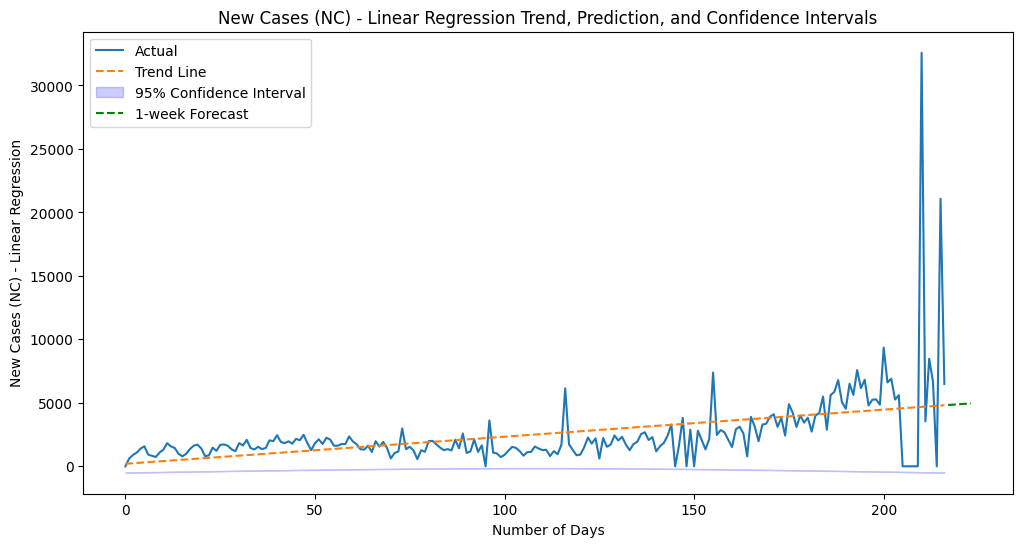

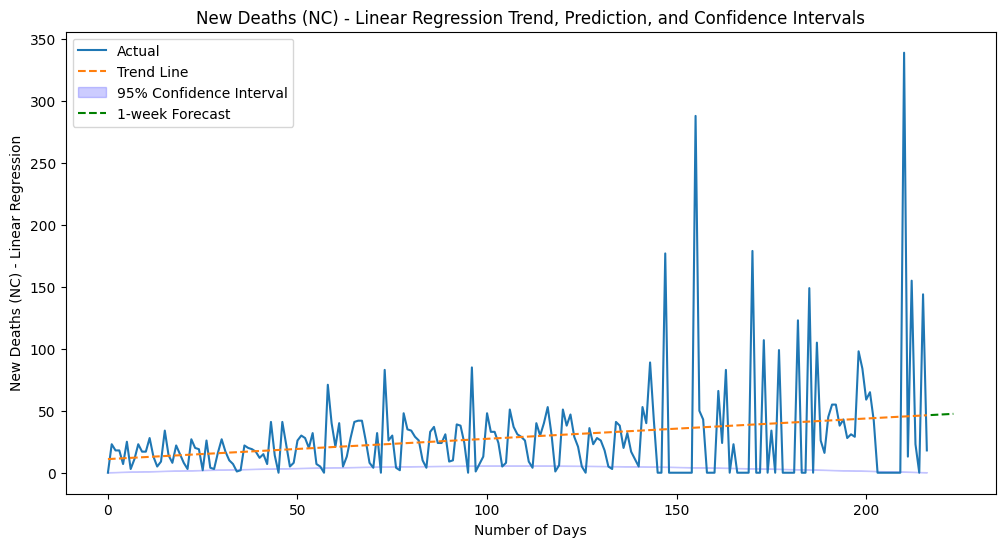

RMSE for Linear Regression (New Cases, NC): 2637.93
RMSE for Linear Regression (New Deaths, NC): 40.22


In [77]:
# Extracting X and y for the entire state of North Carolina
X_nc = np.arange(len(nc_data_filtered)).reshape(-1, 1)
y_nc_new_cases = nc_data_filtered['Calculated New Cases'].values
y_nc_new_deaths = nc_data_filtered['Calculated New Deaths'].values

# Fitting linear regression models
linear_model_new_cases_nc = fit_linear_regression(X_nc, y_nc_new_cases)
linear_model_new_deaths_nc = fit_linear_regression(X_nc, y_nc_new_deaths)

# Predictions for the entire state
y_pred_linear_new_cases_nc = linear_model_new_cases_nc.predict(X_nc)
y_pred_linear_new_deaths_nc = linear_model_new_deaths_nc.predict(X_nc)

# Calculating RMSE for North Carolina
rmse_linear_new_cases_nc = calculate_rmse(y_nc_new_cases, y_pred_linear_new_cases_nc)
rmse_linear_new_deaths_nc = calculate_rmse(y_nc_new_deaths, y_pred_linear_new_deaths_nc)


# Calculating confidence intervals for North Carolina
confidence_interval_nc_new_cases = calculate_confidence_intervals(linear_model_new_cases_nc, X_nc, y_nc_new_cases)
confidence_interval_nc_new_deaths = calculate_confidence_intervals(linear_model_new_deaths_nc, X_nc, y_nc_new_deaths)

# Plotting the results for North Carolina with confidence intervals
plot_regression_results(X_nc, y_nc_new_cases, y_pred_linear_new_cases_nc, 'New Cases (NC) - Linear Regression',
                        confidence_interval=confidence_interval_nc_new_cases,
                        forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                        forecast_values=linear_model_new_cases_nc.predict(X_nc[-1] + np.arange(1, 8).reshape(-1, 1)))

plot_regression_results(X_nc, y_nc_new_deaths, y_pred_linear_new_deaths_nc, 'New Deaths (NC) - Linear Regression',
                        confidence_interval=confidence_interval_nc_new_deaths,
                        forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                        forecast_values=linear_model_new_deaths_nc.predict(X_nc[-1] + np.arange(1, 8).reshape(-1, 1)))


print(f"RMSE for Linear Regression (New Cases, NC): {rmse_linear_new_cases_nc:.2f}")
print(f"RMSE for Linear Regression (New Deaths, NC): {rmse_linear_new_deaths_nc:.2f}")

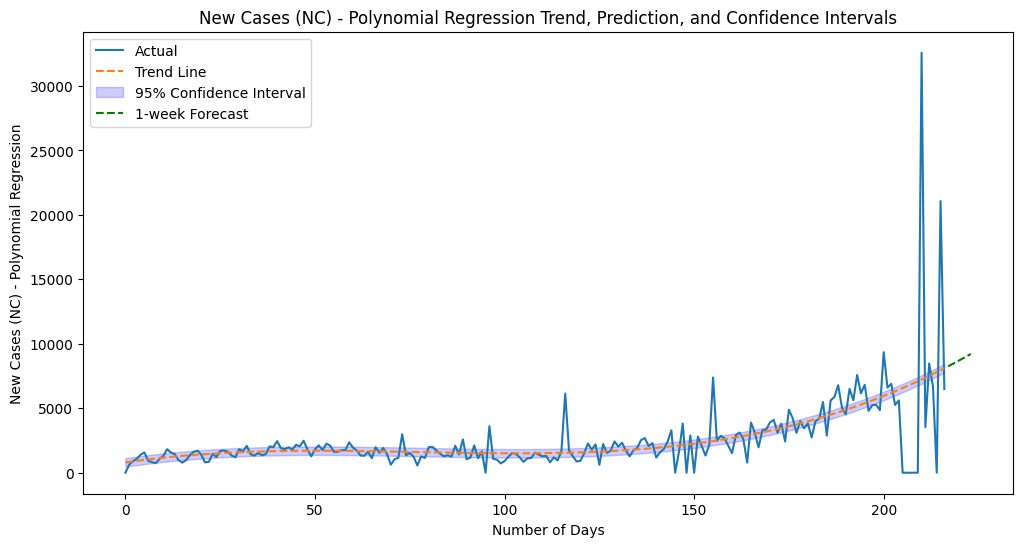

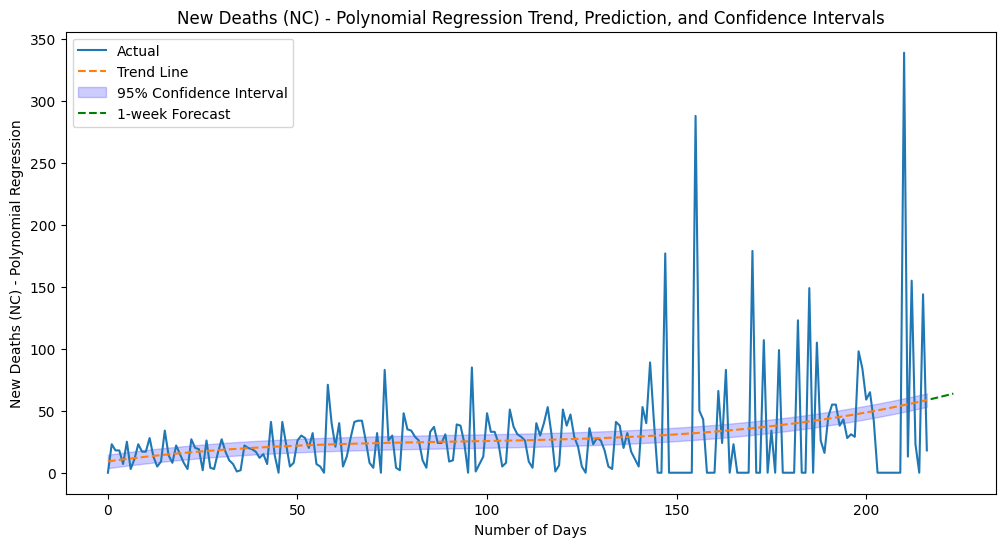

RMSE for Polynomial Regression (New Cases, NC): 2429.78
RMSE for Polynomial Regression (New Deaths, NC): 40.06


In [78]:
# Fitting polynomial regression models
degree = 3
poly_model_new_cases_nc, poly_nc = fit_polynomial_regression(X_nc, y_nc_new_cases, degree)
poly_model_new_deaths_nc, _ = fit_polynomial_regression(X_nc, y_nc_new_deaths, degree)

# Predictions for the entire state
X_poly_nc = poly_nc.transform(X_nc)
y_pred_poly_new_cases_nc = poly_model_new_cases_nc.predict(X_poly_nc)
y_pred_poly_new_deaths_nc = poly_model_new_deaths_nc.predict(X_poly_nc)

# Calculating RMSE for North Carolina
rmse_poly_new_cases_nc = calculate_rmse(y_nc_new_cases, y_pred_poly_new_cases_nc)
rmse_poly_new_deaths_nc = calculate_rmse(y_nc_new_deaths, y_pred_poly_new_deaths_nc)

# Calculating confidence intervals for Polynomial Regression in North Carolina
confidence_interval_poly_new_cases_nc = calculate_confidence_intervals_poly(poly_model_new_cases_nc, X_nc, poly_nc, y_nc_new_cases)
confidence_interval_poly_new_deaths_nc = calculate_confidence_intervals_poly(poly_model_new_deaths_nc, X_nc, poly_nc, y_nc_new_deaths)

# Plotting the results for North Carolina with confidence intervals and labels for Polynomial Regression
plot_regression_results_poly(X_nc, y_nc_new_cases, y_pred_poly_new_cases_nc, 'New Cases (NC) - Polynomial Regression',
                             poly_nc, confidence_interval=confidence_interval_poly_new_cases_nc,
                             forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                             forecast_values=poly_model_new_cases_nc.predict(poly_nc.transform(X_nc[-1] + np.arange(1, 8).reshape(-1, 1))))

plot_regression_results_poly(X_nc, y_nc_new_deaths, y_pred_poly_new_deaths_nc, 'New Deaths (NC) - Polynomial Regression',
                             poly_nc, confidence_interval=confidence_interval_poly_new_deaths_nc,
                             forecast_dates=X_nc[-1] + np.arange(1, 8).reshape(-1, 1),
                             forecast_values=poly_model_new_deaths_nc.predict(poly_nc.transform(X_nc[-1] + np.arange(1, 8).reshape(-1, 1))))

print(f"RMSE for Polynomial Regression (New Cases, NC): {rmse_poly_new_cases_nc:.2f}")
print(f"RMSE for Polynomial Regression (New Deaths, NC): {rmse_poly_new_deaths_nc:.2f}")

## Plotting  linear regression results for each county

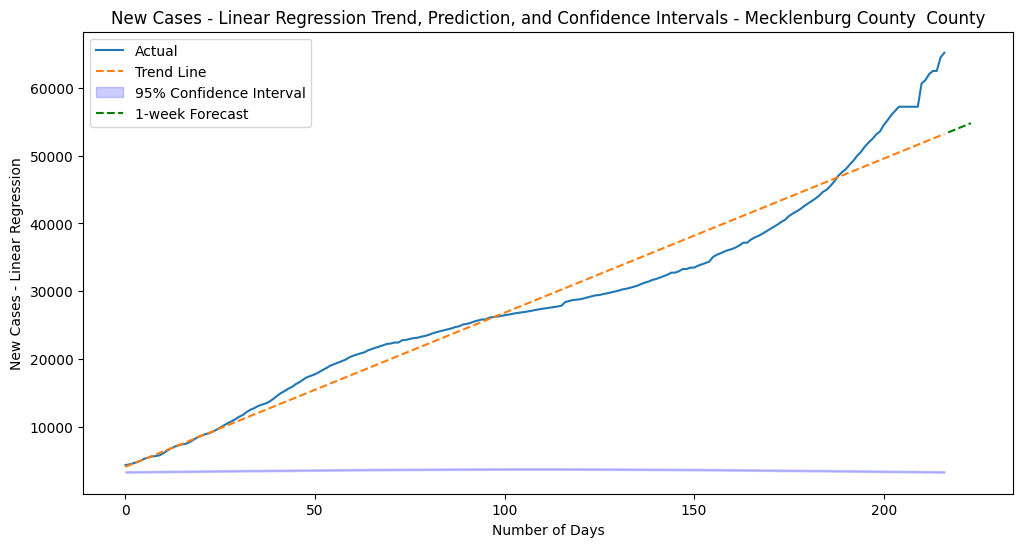

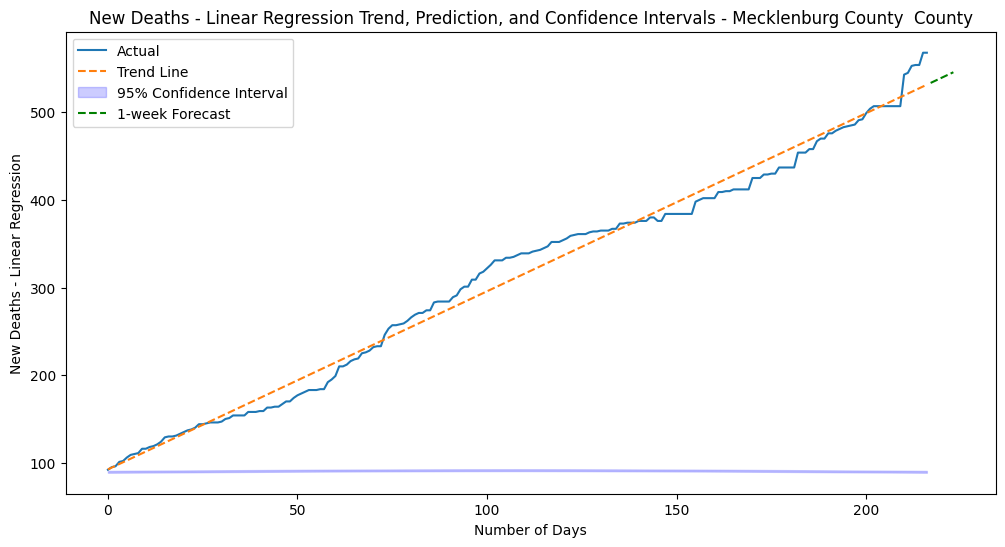


Mecklenburg County  County:
RMSE for Linear Regression (New Cases): 3272.67
RMSE for Linear Regression (New Deaths): 14.39


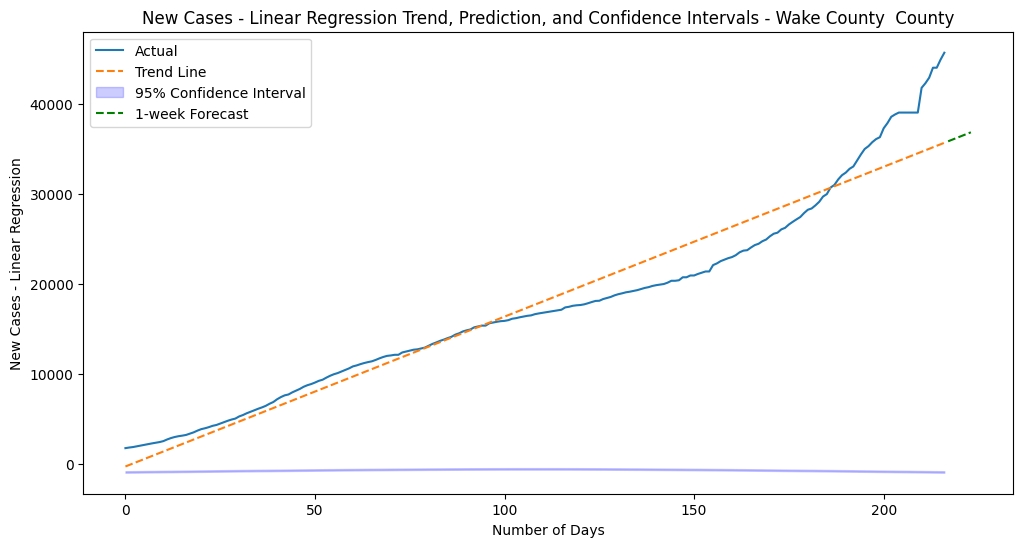

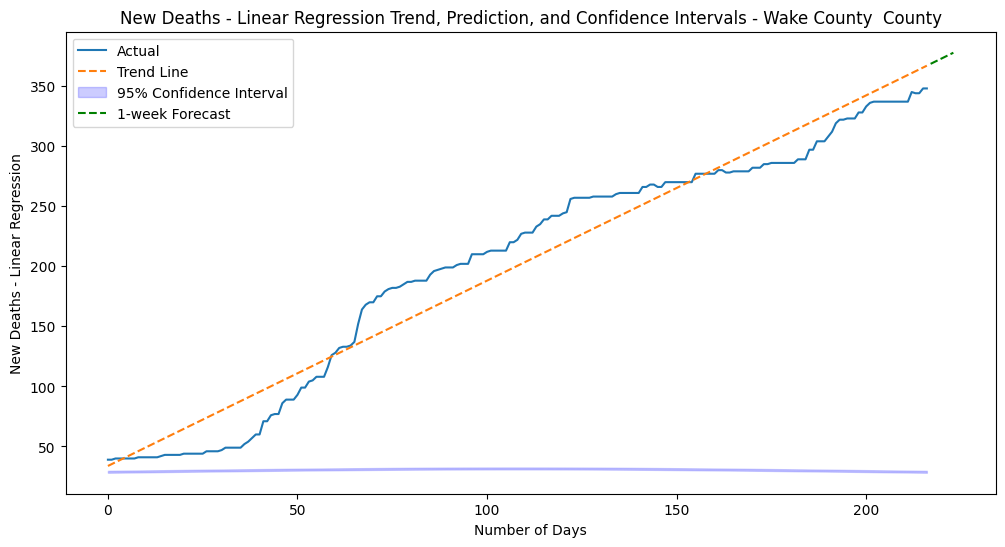


Wake County  County:
RMSE for Linear Regression (New Cases): 2601.16
RMSE for Linear Regression (New Deaths): 21.14


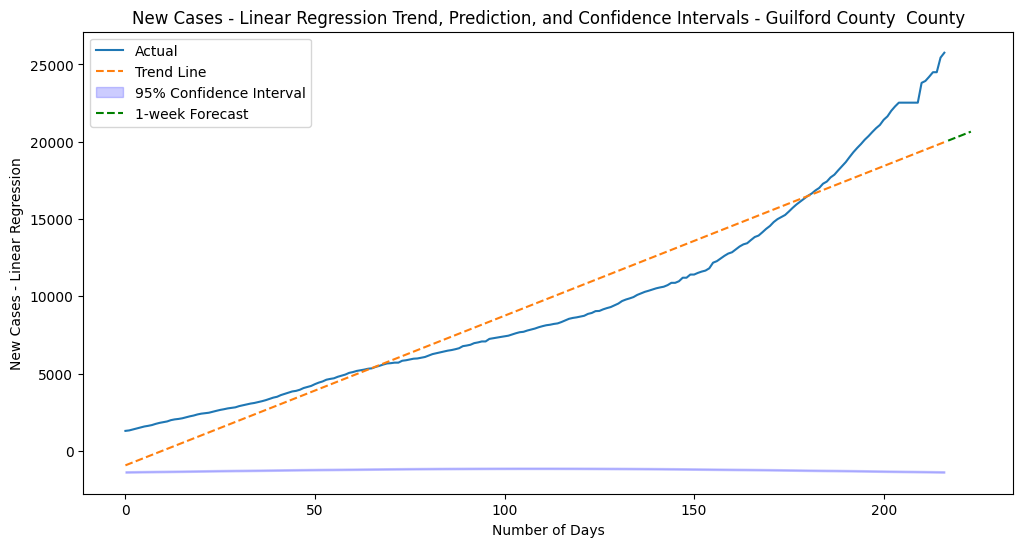

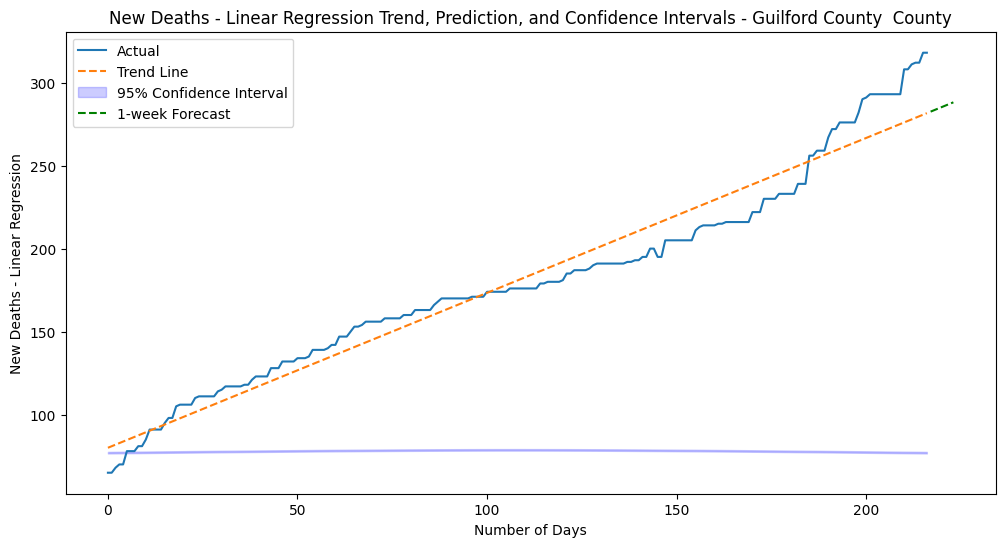


Guilford County  County:
RMSE for Linear Regression (New Cases): 1793.53
RMSE for Linear Regression (New Deaths): 12.84


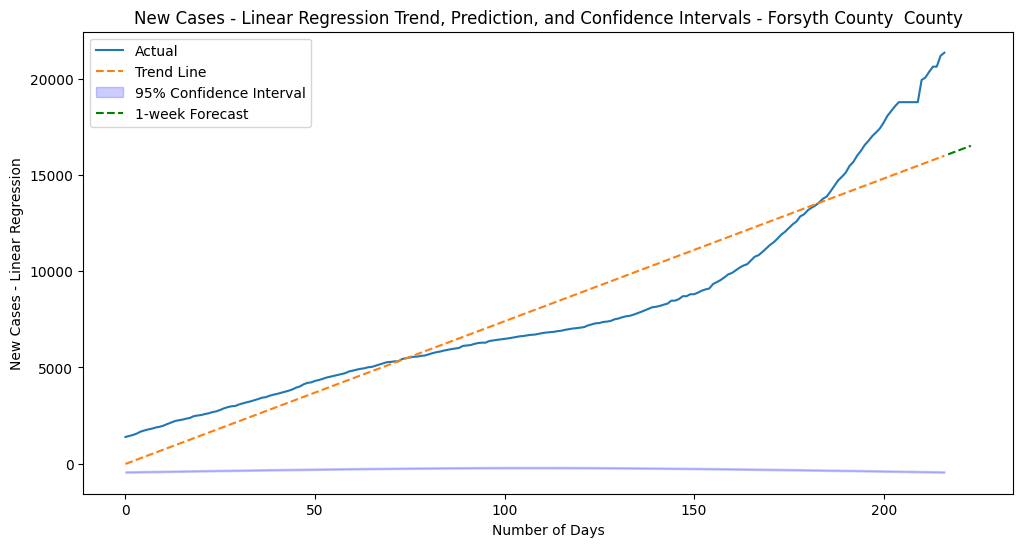

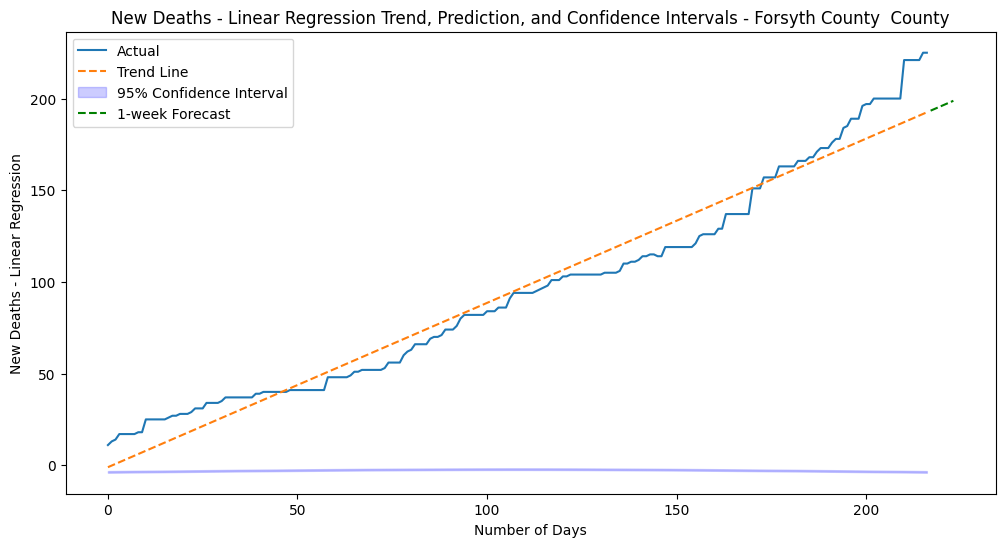


Forsyth County  County:
RMSE for Linear Regression (New Cases): 1714.95
RMSE for Linear Regression (New Deaths): 11.31


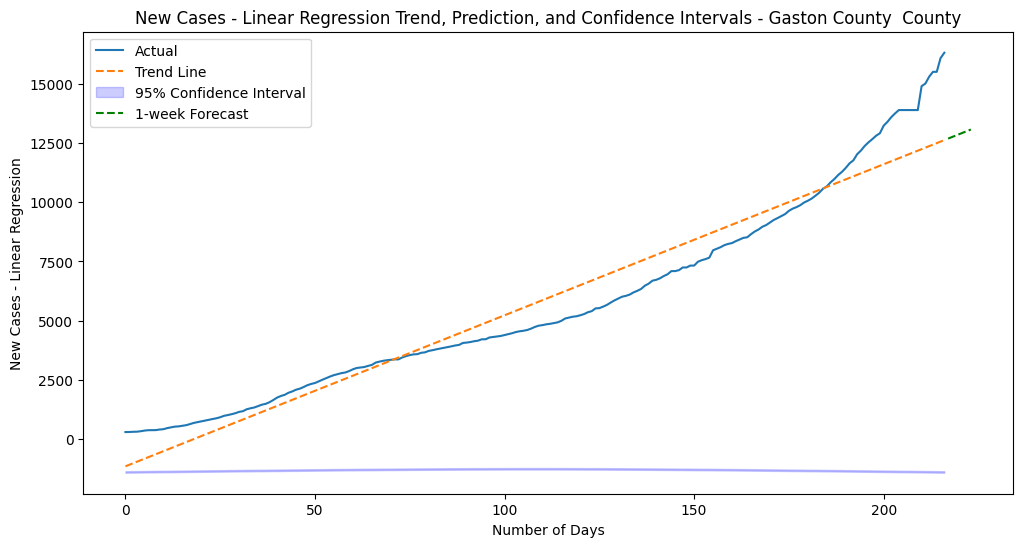

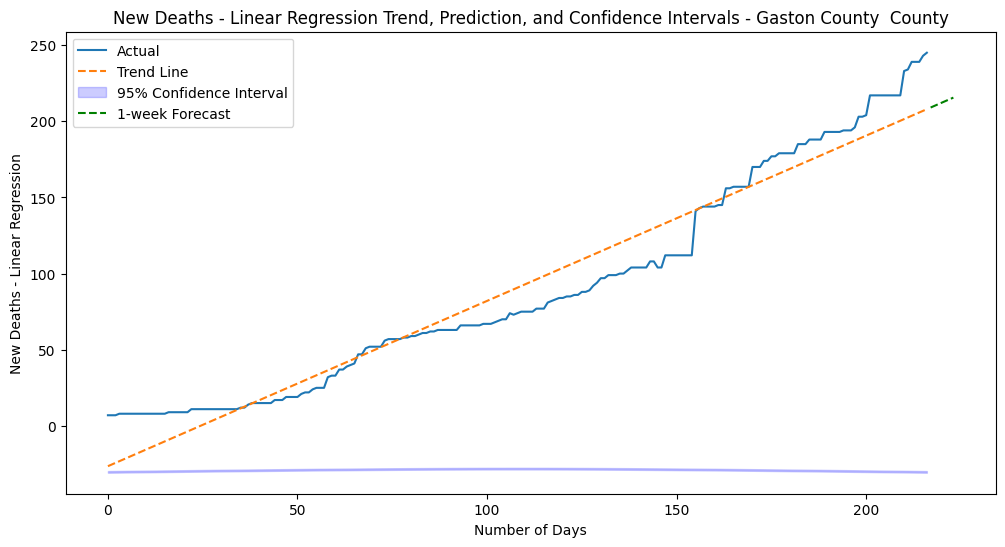


Gaston County  County:
RMSE for Linear Regression (New Cases): 1015.37
RMSE for Linear Regression (New Deaths): 16.10


In [79]:
# Identify top 5 counties
top_counties_list = top_counties(nc_data_updated)


for county in top_counties_list:
    county_data = nc_data_updated[nc_data_updated['County Name'] == county]
    X_county = np.arange(len(county_data)).reshape(-1, 1)
    y_county_new_cases = county_data['Cases'].values
    y_county_new_deaths = county_data['Deaths'].values

    # Linear regression models
    linear_model_new_cases_county = fit_linear_regression(X_county, y_county_new_cases)
    linear_model_new_deaths_county = fit_linear_regression(X_county, y_county_new_deaths)

    # Predictions
    y_pred_linear_new_cases_county = linear_model_new_cases_county.predict(X_county)
    y_pred_linear_new_deaths_county = linear_model_new_deaths_county.predict(X_county)

    # Calculating RMSE for each county
    rmse_linear_new_cases_county = calculate_rmse(y_county_new_cases, y_pred_linear_new_cases_county)
    rmse_linear_new_deaths_county = calculate_rmse(y_county_new_deaths, y_pred_linear_new_deaths_county)

    # Calculating confidence intervals
    confidence_interval_new_cases_county = calculate_confidence_intervals(linear_model_new_cases_county, X_county, y_county_new_cases)
    confidence_interval_new_deaths_county = calculate_confidence_intervals(linear_model_new_deaths_county, X_county, y_county_new_deaths)

    # Plotting the results for each county with confidence intervals
    plot_county_regression(county_data, county, X_county, y_county_new_cases,
                           y_pred_linear_new_cases_county, 'New Cases - Linear Regression',
                           confidence_interval=confidence_interval_new_cases_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=linear_model_new_cases_county.predict(X_county[-1] + np.arange(1, 8).reshape(-1, 1)))

    plot_county_regression(county_data, county, X_county, y_county_new_deaths,
                           y_pred_linear_new_deaths_county, 'New Deaths - Linear Regression',
                           confidence_interval=confidence_interval_new_deaths_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=linear_model_new_deaths_county.predict(X_county[-1] + np.arange(1, 8).reshape(-1, 1)))

    print(f"\n{county} County:")
    print(f"RMSE for Linear Regression (New Cases): {rmse_linear_new_cases_county:.2f}")
    print(f"RMSE for Linear Regression (New Deaths): {rmse_linear_new_deaths_county:.2f}")


## Plotting regression results for each county

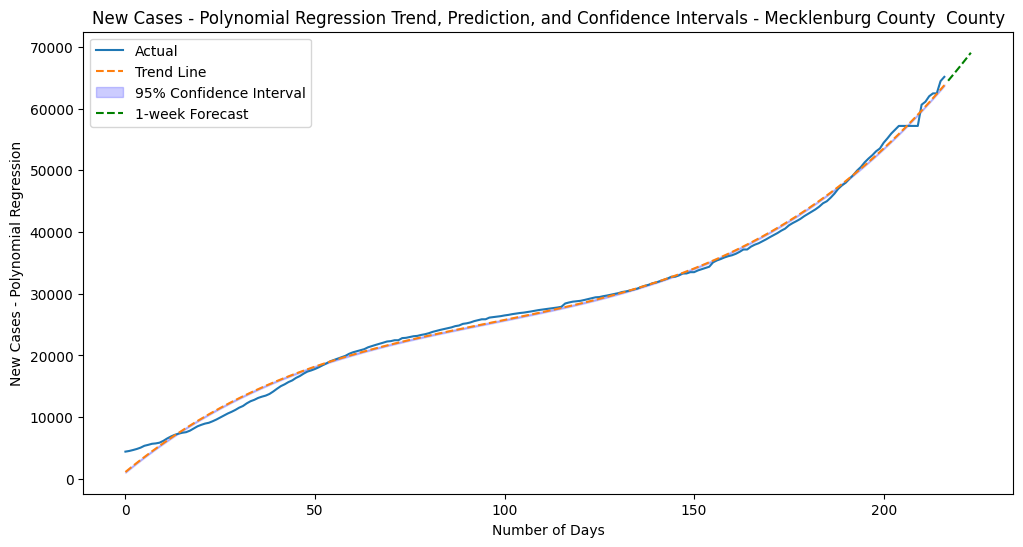

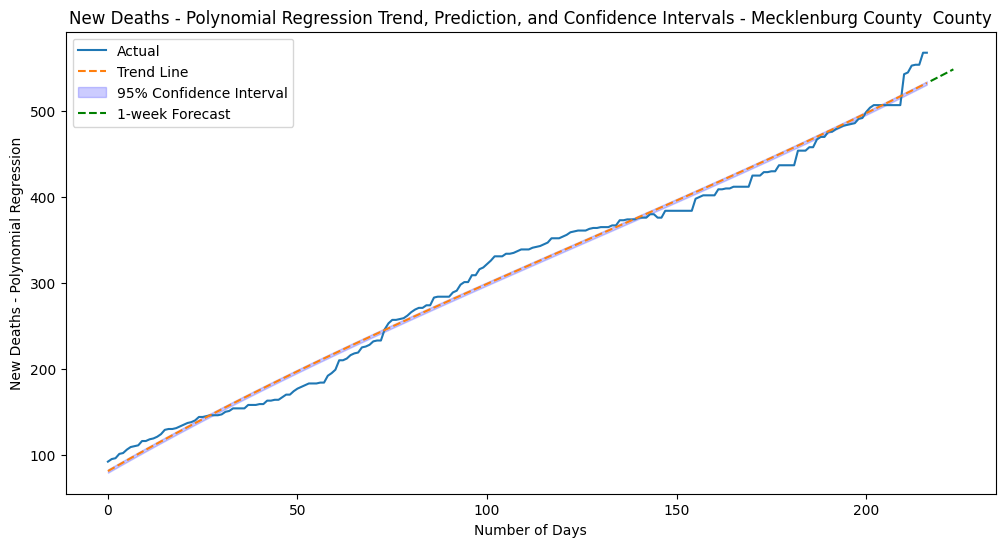


Mecklenburg County  County:
RMSE for Polynomial Regression (New Cases): 854.40
RMSE for Polynomial Regression (New Deaths): 13.98


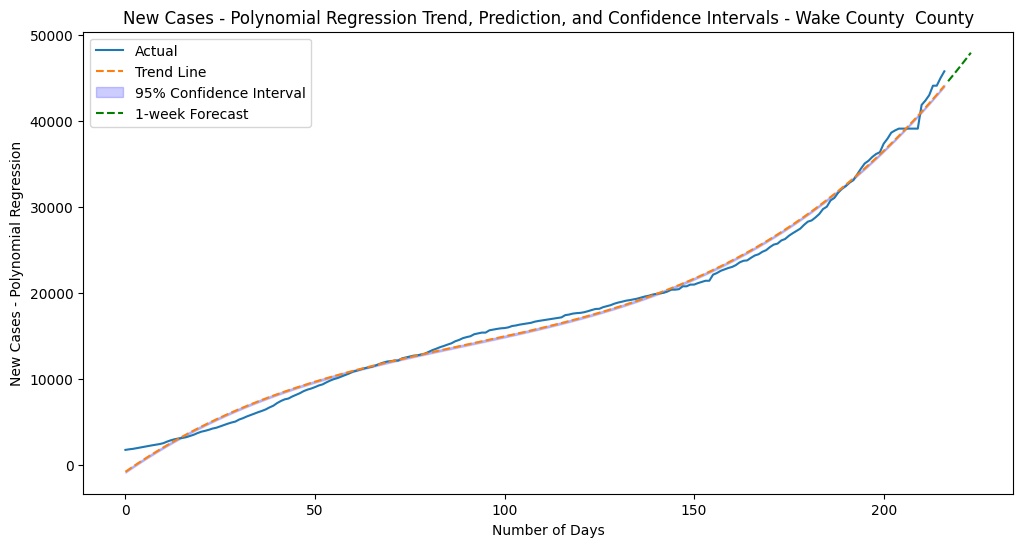

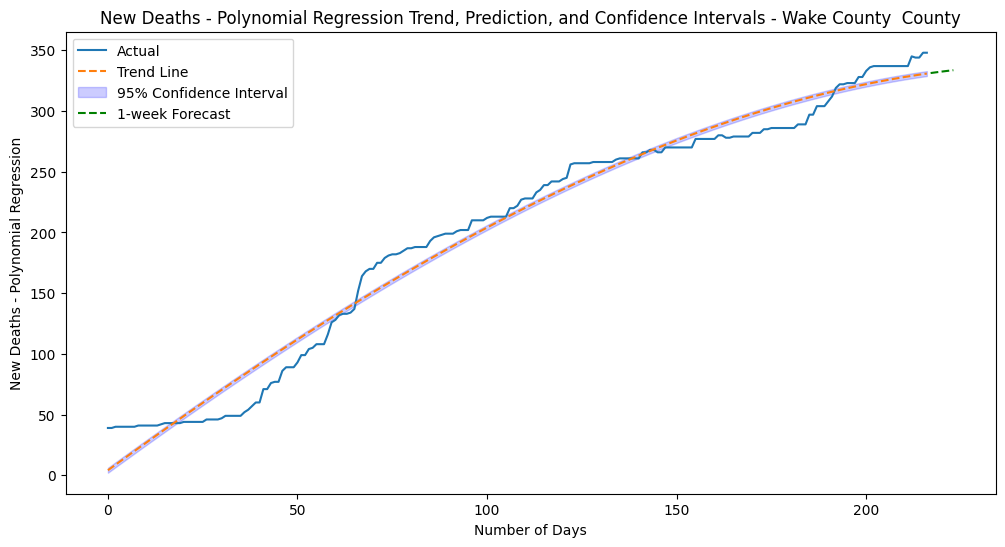


Wake County  County:
RMSE for Polynomial Regression (New Cases): 815.58
RMSE for Polynomial Regression (New Deaths): 14.94


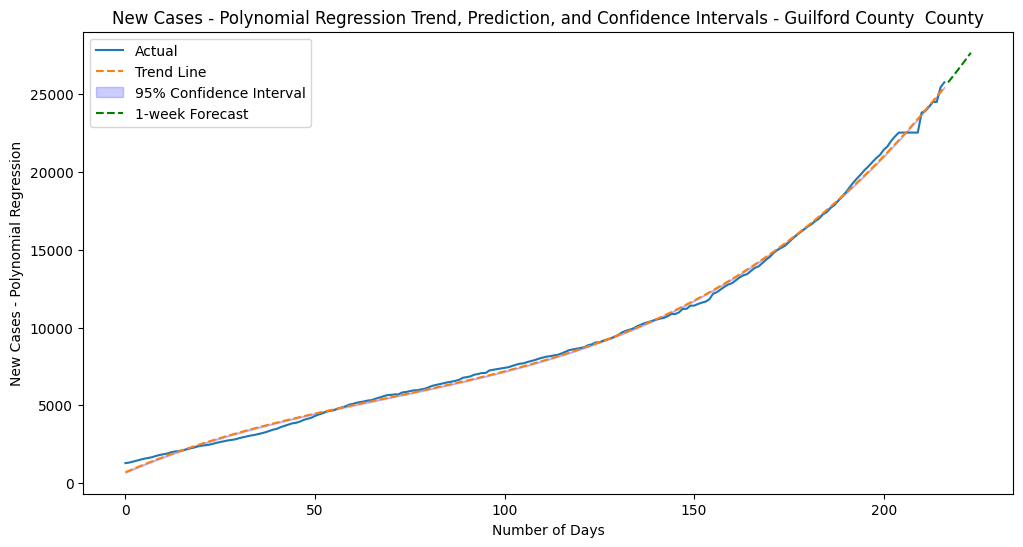

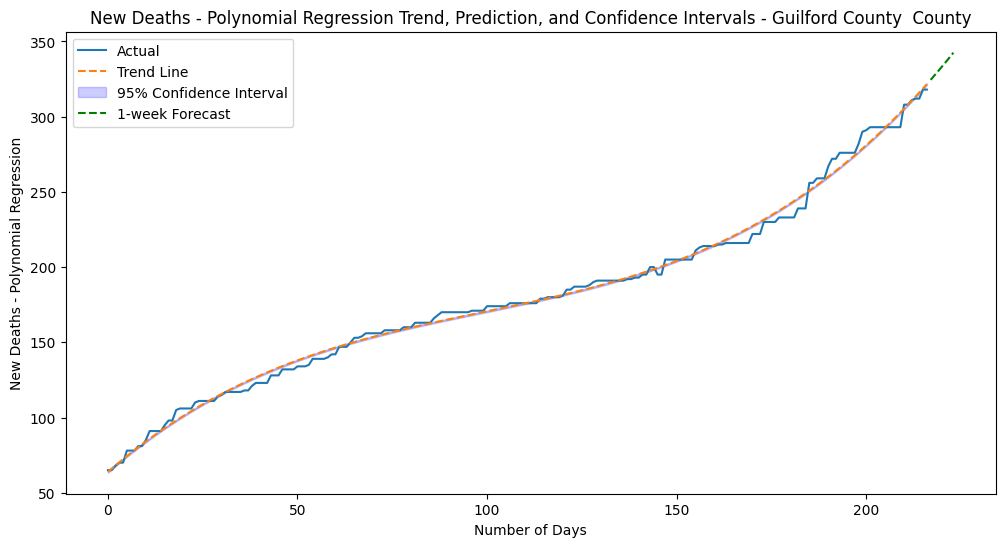


Guilford County  County:
RMSE for Polynomial Regression (New Cases): 240.85
RMSE for Polynomial Regression (New Deaths): 4.06


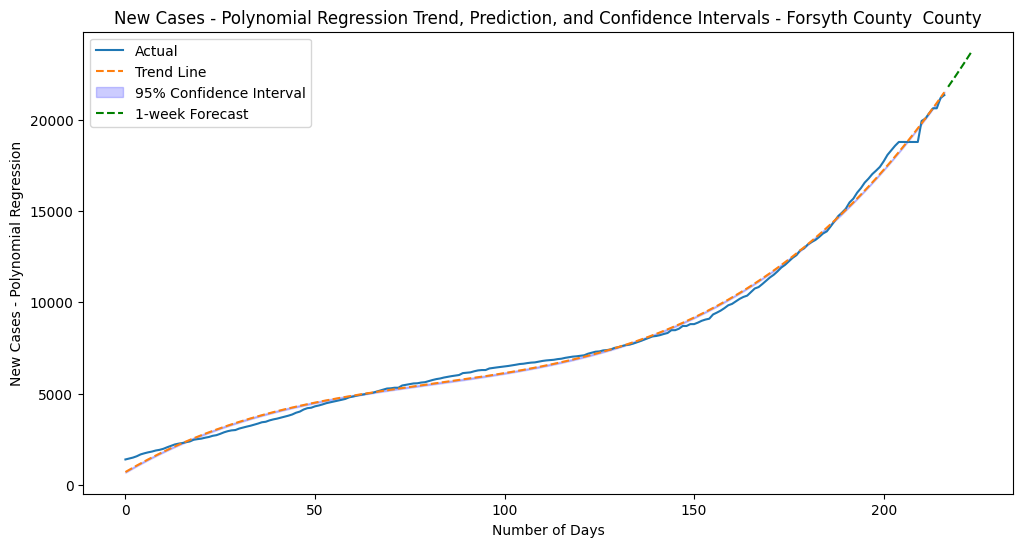

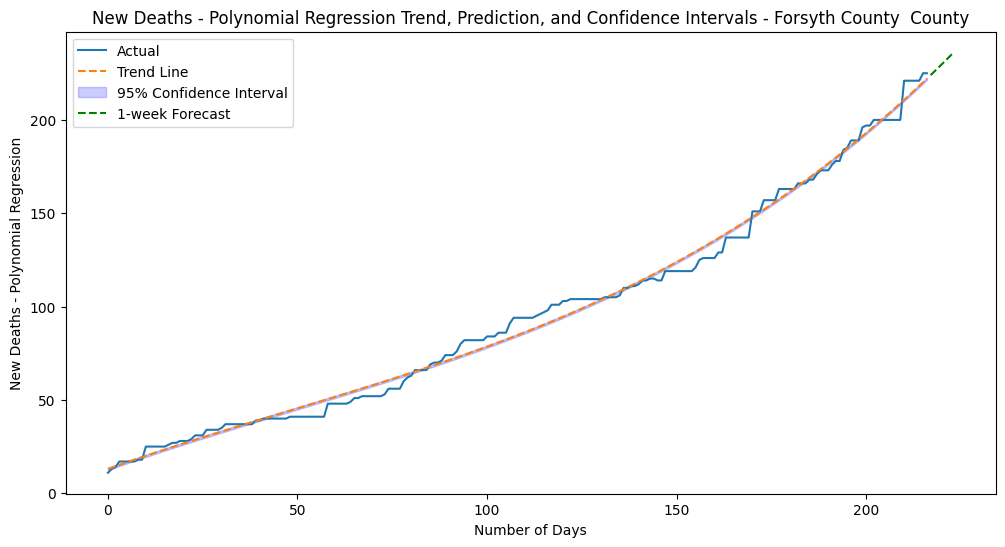


Forsyth County  County:
RMSE for Polynomial Regression (New Cases): 281.39
RMSE for Polynomial Regression (New Deaths): 4.59


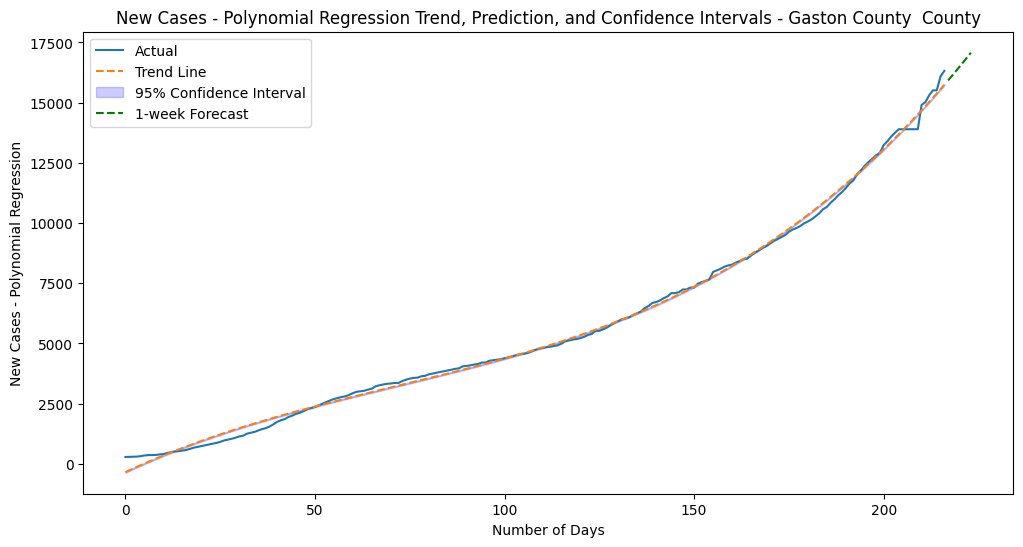

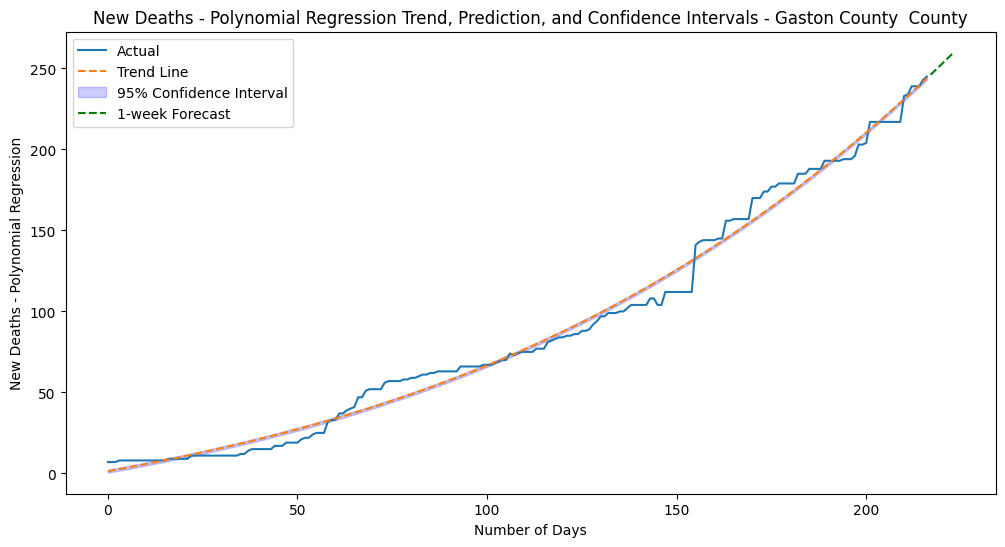


Gaston County  County:
RMSE for Polynomial Regression (New Cases): 191.21
RMSE for Polynomial Regression (New Deaths): 6.90


In [82]:

for county in top_counties_list:
    county_data = nc_data_updated[nc_data_updated['County Name'] == county]
    X_county = np.arange(len(county_data)).reshape(-1, 1)
    y_county_new_cases = county_data['Cases'].values
    y_county_new_deaths = county_data['Deaths'].values

    # Polynomial regression models
    poly_model_new_cases_county, poly_county = fit_polynomial_regression(X_county, y_county_new_cases, degree)
    poly_model_new_deaths_county, _ = fit_polynomial_regression(X_county, y_county_new_deaths, degree)

    # Predictions
    X_poly_county = poly_county.transform(X_county)
    y_pred_poly_new_cases_county = poly_model_new_cases_county.predict(X_poly_county)
    y_pred_poly_new_deaths_county = poly_model_new_deaths_county.predict(X_poly_county)

    # Calculating RMSE for each county
    rmse_poly_new_cases_county = calculate_rmse(y_county_new_cases, y_pred_poly_new_cases_county)
    rmse_poly_new_deaths_county = calculate_rmse(y_county_new_deaths, y_pred_poly_new_deaths_county)

    # Calculating Confidence Intervals
    confidence_interval_poly_new_cases_county = calculate_confidence_intervals_poly(poly_model_new_cases_county, X_county, poly_county, y_county_new_cases)
    confidence_interval_poly_new_deaths_county = calculate_confidence_intervals_poly(poly_model_new_deaths_county, X_county, poly_county, y_county_new_deaths)

    # Plotting the results for each county with confidence intervals and labels for polynomial regression
    plot_county_regression(county_data, county, X_county, y_county_new_cases,
                           y_pred_poly_new_cases_county, 'New Cases - Polynomial Regression',
                           confidence_interval=confidence_interval_poly_new_cases_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=poly_model_new_cases_county.predict(poly_county.transform(X_county[-1] + np.arange(1, 8).reshape(-1, 1))))

    plot_county_regression(county_data, county, X_county, y_county_new_deaths,
                           y_pred_poly_new_deaths_county, 'New Deaths - Polynomial Regression',
                           confidence_interval=confidence_interval_poly_new_deaths_county,
                           forecast_dates=X_county[-1] + np.arange(1, 8).reshape(-1, 1),
                           forecast_values=poly_model_new_deaths_county.predict(poly_county.transform(X_county[-1] + np.arange(1, 8).reshape(-1, 1))))


    print(f"\n{county} County:")
    print(f"RMSE for Polynomial Regression (New Cases): {rmse_poly_new_cases_county:.2f}")
    print(f"RMSE for Polynomial Regression (New Deaths): {rmse_poly_new_deaths_county:.2f}")


Taken 95 percent CI, as it is a common statistical practice, where we would be expecting the true parameter (slope in regression) to fall within interval in approximately 95% of replications.